# <span style='color:SteelBlue'>P2 - Analyse des données des systèmes éducatifs</span>

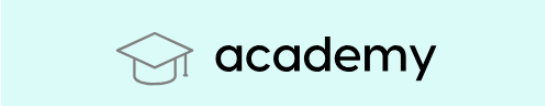

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## <span style='background:Thistle'>1. Introduction</span>

**Academy**
*****

Academy est notre entreprise, une start-up de la EdTech qui propose des **formations en ligne pour les lycéens et les enseignements supérieurs**.

**Mission**
*****

A partir des données de la Banque mondiale, réaliser une pré-analyse exploratoire permettant de répondre aux interrogations suivantes :

- Quels sont les **pays avec un fort potentiel** de clients pour nos services ?
- Pour chacun de ces pays, quelle sera **l’évolution de ce potentiel** de clients ?
- Dans quels pays l'entreprise doit-elle **opérer en priorité** ?

**Source**
*****

[Banque mondiale](http://datatopics.worldbank.org/education/)

**Processus-Stratégie**
***

- Analyse des données (**qualité**, **quantité**, **cohérence des données**)
- Sélection des **indicateurs** les plus **pertinents** pour notre cible :
    - démographique : une population des 15-24 ans élevée,
    - éducatif : pour la tranche 15-24 ans des niveaux lycée et enseignements supérieurs,
    - économique : vérifier les niveaux de vie de la population,
    - numérique : accès à internet inidspensable pour les formations, la proprieté d'un ordinateur ou d'une tablette , l'accès à l'électricité...
- **Score** pour classer le potentiel des pays
- **Prédictions** 
- **Conclusions**

In [2]:
# Chargement des librairies
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import geopandas as gpd 
import IPython as ip
from IPython.display import display
import outils
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import statsmodels as stat
from statsmodels.tsa.api import Holt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import jyquickhelper
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from math import pi
from mpl_toolkits.axes_grid1 import make_axes_locatable
warnings.simplefilter('ignore', ConvergenceWarning)
%matplotlib inline

# Versions 
print('Version des librairies utilisées :')
print('Python        : ' + sys.version)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Matplotlib    : ' + mpl.__version__)
print('Seaborn       : ' + sns.__version__)
print('Sklearn       : ' + sklearn.__version__)
print('Geopandas     : ' + sns.__version__)
print('IPython       : ' + ip.__version__)
print('statsmodels   : ' + stat.__version__)
print('jyquickhelper : ' + jyquickhelper.__version__)
print('Outils        : ' + outils.__version__)

import datetime
now  = datetime.datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
Python        : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
NumPy         : 1.17.4
Pandas        : 1.1.3
Matplotlib    : 3.3.2
Seaborn       : 0.11.0
Sklearn       : 0.23.2
Geopandas     : 0.11.0
IPython       : 7.19.0
statsmodels   : 0.12.1
jyquickhelper : 0.4.220
Outils        : 0.0.3
Lancé le           : 2021-02-15T14:38:48.446747


In [3]:
pd.set_option('display.max_row',200)
pd.set_option('display.max_column',70)
pd.set_option('display.precision', 5)

## <span style='background:Thistle'>2. Description des jeux de données mis à disposition</span>

### <span style='background:PowderBlue'>2.1. Analyse du jeu de données EdStatsCountry.csv</span>

In [4]:
# Chargement du jeu de données
country = pd.read_csv('EdStatsCountry.csv', delimiter=',')

In [5]:
# Contenu des 3 premières lignes
country.head(3);

In [6]:
# Nom des colonnes
country.columns;

In [7]:
# Résumé des variables qualitatives
country.describe(exclude=[np.number]);

In [8]:
# Résumé des variables quantitatives
country.describe();

In [9]:
# Taille : nombre de lignes/colonnes
nRow, nCol = country.shape
print(f'Le jeu de données contient {nRow} lignes et {nCol} colonnes.')

Le jeu de données contient 241 lignes et 32 colonnes.


In [10]:
# Types des variables
# outils.get_types_variables(country, False, False, True)

Valeurs manquantes :2354 NaN pour 7712 données (30.52 %)
-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


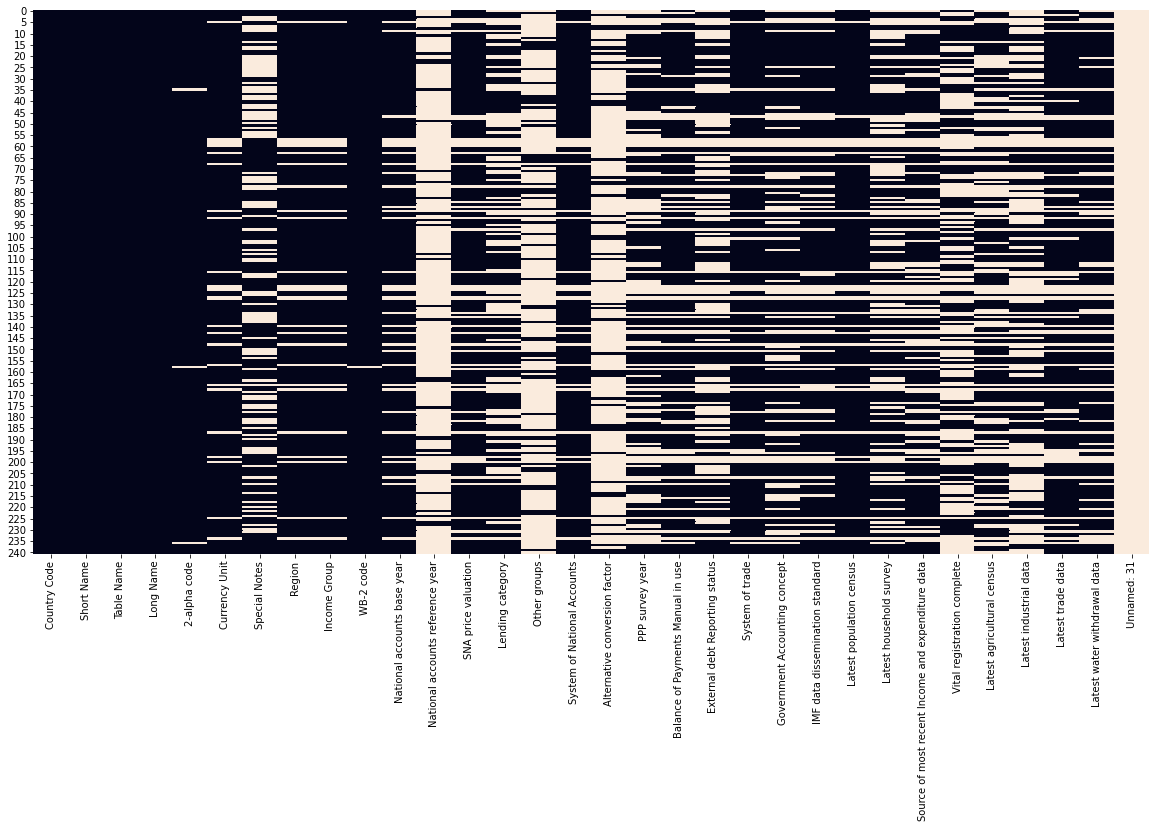

In [11]:
# Valeurs manquantes
outils.get_missing_values(country, False, True)

In [12]:
# Doublons?
doublons = country[country.duplicated(['Country Code'], keep=False)]
nb_doublons_code_pays = doublons.shape[0]
print(f'Nombre de doublons sur le code pays : {nb_doublons_code_pays}')

Nombre de doublons sur le code pays : 0


In [13]:
# Remplacer la région 'NaN' par 'Autres'
country['Region'] = country['Region'].replace(np.nan, 'A Completer')
print('Régions :\n',country['Region'].unique())
# Remplacer le groupe de revenus 'NaN' par 'Autres'
country['Income Group'] = country['Income Group'].replace(np.nan, 'A Completer')
print('\nGroupes de revenus :\n',country['Income Group'].unique())

Régions :
 ['Latin America & Caribbean' 'South Asia' 'Sub-Saharan Africa'
 'Europe & Central Asia' 'A Completer' 'Middle East & North Africa'
 'East Asia & Pacific' 'North America']

Groupes de revenus :
 ['High income: nonOECD' 'Low income' 'Upper middle income' 'A Completer'
 'Lower middle income' 'High income: OECD']


**Pays / Régions / Groupes de revenus**

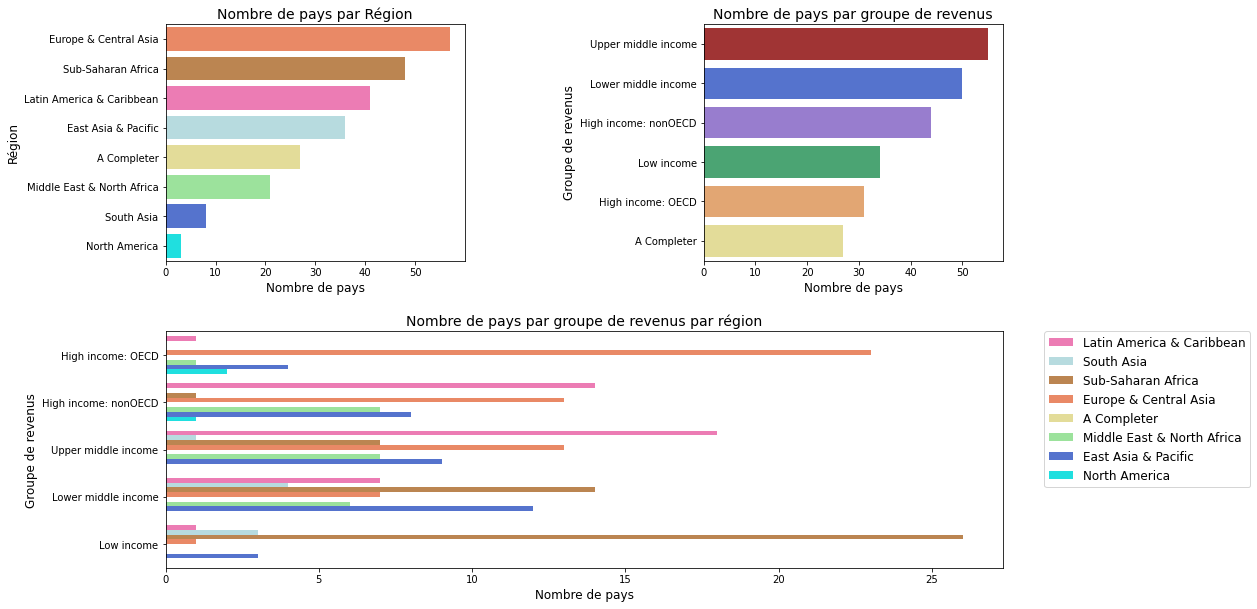

In [14]:
# Regroupement des pays/régions/groupes de revenus

fig=plt.figure(figsize=(15,10))
grid = plt.GridSpec(2, 2, wspace=0.8, hspace=0.3)

# Graphique ligne 1, colonne 1 ------------------
plt.subplot(grid[0, 0])
# Regroupement des pays par régions
nb_pays_par_region=country.groupby('Region')[['Short Name']].count().reset_index().sort_values(by='Short Name', ascending=False)
colors = ['Coral','Peru','HotPink','PowderBlue','Khaki','LightGreen','RoyalBlue','Cyan']
sns.barplot(nb_pays_par_region['Short Name'].sort_values(), nb_pays_par_region['Region'], palette=colors,)
plt.xlabel('Nombre de pays', fontsize=12)
plt.ylabel('Région', fontsize=12)
plt.title('Nombre de pays par Région', fontsize=14)

# Graphique ligne 1, colonne 2 ------------------
plt.subplot(grid[0, 1])
# Regroupement des pays par groupe de revenus
nb_pays_par_groupe_revenu=country.groupby('Income Group')[['Short Name']].count().reset_index().sort_values(by='Short Name', ascending=False)
colors = ['FireBrick','RoyalBlue','MediumPurple','MediumSeaGreen','SandyBrown','Khaki']
sns.barplot(nb_pays_par_groupe_revenu['Short Name'].sort_values(), nb_pays_par_groupe_revenu['Income Group'], palette=colors)
plt.xlabel('Nombre de pays', fontsize=12)
plt.ylabel('Groupe de revenus', fontsize=12)
plt.title('Nombre de pays par groupe de revenus', fontsize=14)

# Graphique ligne 2, sur les 2 colonnes ------------------
plt.subplot(grid[1, :])
# Regroupement des pays par groupe de revenus
colors = ['HotPink','PowderBlue','Peru','Coral','Khaki','LightGreen','RoyalBlue','Cyan']
sns.countplot(y='Income Group', hue='Region', data=country, orient='h',
                   order=['High income: OECD', 'High income: nonOECD', 'Upper middle income', 'Lower middle income', 'Low income'],
                   palette=colors)
plt.xlabel('Nombre de pays', fontsize=12)
plt.ylabel('Groupe de revenus', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.title('Nombre de pays par groupe de revenus par région', fontsize=14)
plt.grid(False)

plt.show()

***
**Bilan sur le jeu de données EdStatsCountry.csv**: </span>
***

-	Le dataset contient des informations géographiques sur les pays (**codes ISO-3166 alpha 3 et 2**, code WB-2 et 3, les **noms des pays**, les regroupements pour 7 **régions,** par **groupe de revenus**…), des données économiques globales et des dates de référence des dernières études.
-	Le jeu de données contient **241 lignes et 32 colonnes**.
-	Nombre de **valeurs manquantes** totales : 2354 NaN pour 7712 observations (**30.52 %**).
-	Pas de doublons.
-	Aucune dobservation dupliquée sur les noms des pays et les codes pays. 
-	Toutes les régions du monde sont représentées.

***
*Notes :* à garder en mémoire si on utilise ce jeu de données
***

-	Certaines colonnes sont en float et contiennent des dates (années) : à transformer.
-	La colonne **Unnamed:31** est vide et devra être supprimée.
-	Toutes les régions du monde sont représentées.

### <span style='background:PowderBlue'>2.2. Analyse du jeu de données EdStatsCountry-Series.csv</span>

In [15]:
# Chargement du jeu de données
country_series = pd.read_csv('EdStatsCountry-Series.csv', delimiter=',')

In [16]:
# Contenu des 3 premières lignes
country_series.head(3);

In [17]:
# Contenu des 3 dernières colonnes
country_series.tail(3);

In [18]:
# Nom des colonnes
country_series.columns.to_list();

In [19]:
# Résumé des variables qualitatives
country_series.describe(exclude=[np.number]);

In [20]:
# Résumé des variables quantitatives
country_series.describe();

In [21]:
# Taille : nombre de lignes/colonnes
nRow, nCol = country_series.shape
print(f'Le jeu de données contient {nRow} lignes et {nCol} colonnes.')

Le jeu de données contient 613 lignes et 4 colonnes.


In [22]:
# Types des variables
# outils.get_types_variables(country_series, False, False, True)

Valeurs manquantes :613 NaN pour 2452 données (25.0 %)
-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


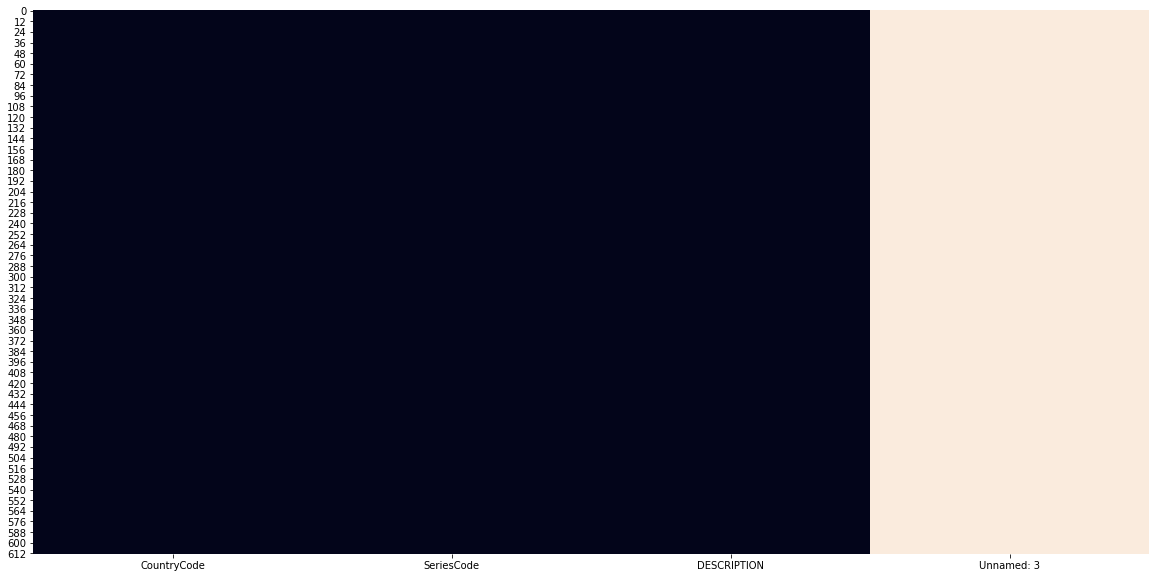

In [23]:
# Valeurs manquantes
outils.get_missing_values(country_series, False, True)

In [24]:
# Doublon ? avec toutes les colonnes du dataframe
country_series[country_series.duplicated(keep=False)].shape[0];

In [25]:
# Doublons sur les 2 colonnes CountryCode et SeriesCode
country_series[country_series.duplicated(['CountryCode', 'SeriesCode'], keep=False)].shape[0];

In [26]:
# Doublons sur les 3 colonnes CountryCode, SeriesCode et DESCRIPTION
country_series[country_series.duplicated(['CountryCode', 'SeriesCode', 'DESCRIPTION'], keep=False)].shape[0];

**Pays présents dans EdStatsCountry.csv mais pas dans ce jeu de données EdStatsCountry-Series.csv**

In [27]:
# Le nombre de code ISO aplha 3 ne correspond pas au code ISO alpha 3 du jeu de données EdStatsCountry.csv.
country['Country Code'].nunique() == country_series['CountryCode'].nunique()

False

In [28]:
# Recherche des noms des pays n'apparaissant pas dans le jeu de données EdStatsCountry-Series.csv
country[~country['Country Code'].isin(country_series['CountryCode'])][['Short Name']].sort_values(by = 'Short Name');

Les pays en plus dans le jeu de données EdStatsCountry.csv sont :
- des noms de région, 
- ou des noms de regroupement de revenus, 
- ou certains regroupement de pays (European Union, Arab World..),
- et des pays (Curaçao).

**Pays / Code indicateur / Description**

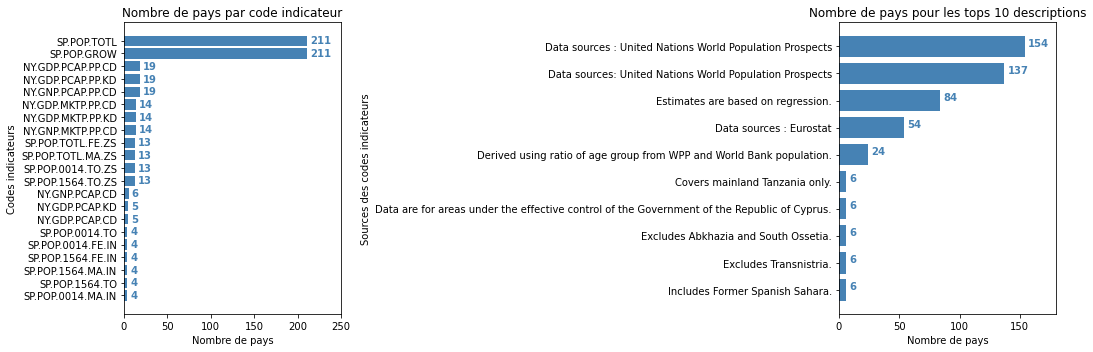

In [29]:
# Regroupement des pays par code indicateur et des pays par description

fig, ax = plt.subplots(1, 2, figsize=(15, 5))  

# Graphique ligne 1, colonne 1 ------------------
# Regroupement des pays par code indicateur
serie_code = country_series.groupby('SeriesCode')[['CountryCode']].count().reset_index().sort_values(by='CountryCode')['SeriesCode']
nb_pays_par_serie_code=country_series.groupby('SeriesCode')[['CountryCode']].count()['CountryCode'].sort_values()
ax1=ax[0]
ax1.barh(y = serie_code, width=nb_pays_par_serie_code, color='SteelBlue')
for i, v in enumerate(nb_pays_par_serie_code):
    ax1.text(v + 3, i - .22, str(v), color='SteelBlue', fontsize=10, fontweight='bold')
ax1.set_title('Nombre de pays par code indicateur', fontsize=12)
ax1.set_xlabel('Nombre de pays', fontsize=10)
ax1.set_ylabel('Codes indicateurs', fontsize=10)
ax1.tick_params(labelsize=10)
ax1.set_xlim([0, 250])
ax1.grid(False)

# Graphique ligne 1, colonne 2 ------------------
# Regroupement des pays par les 10 descriptions des sources des indicateurs les plus fréquentes
description = country_series.groupby('DESCRIPTION')[['CountryCode']].count().reset_index().sort_values(by='CountryCode')['DESCRIPTION'].tail(10)
nb_pays_par_description=country_series.groupby('DESCRIPTION')[['CountryCode']].count()['CountryCode'].sort_values().tail(10)
ax2=ax[1]
ax2.barh(y = description, width=nb_pays_par_description, color='SteelBlue')
for i, v in enumerate(nb_pays_par_description):
    ax2.text(v + 3, i + .01, str(v), color='SteelBlue', fontsize=10, fontweight='bold')
ax2.set_title('Nombre de pays pour les tops 10 descriptions', fontsize=12)
ax2.set_xlabel('Nombre de pays', fontsize=10)
ax2.set_ylabel('Sources des codes indicateurs', fontsize=10)
ax2.tick_params(labelsize=10)
ax2.set_xlim([0, 180])
ax2.grid(False)

fig.tight_layout()
plt.show()

***
**Bilan sur le jeu de données EdStatsCountry-Series.csv** : 
***

-  Le jeu de données contient les **références des sources de certains indicateurs par pays** présents dans le jeu de données EdStatsCountry.csv.
-  Le jeu de données contient **613 lignes et 4 colonnes**. 
-  Nombre de **valeurs manquantes** totales : 613 NaN pour 2452 données (**25.0 %**), les 3 premières colonnes ('Country Code', 'Serie Code' et 'Description') n’ont pas de valeurs manquantes.

***
*Notes : à garder en mémoire si on utilise ce jeu de données*
***

-  Les **pays en plus** (241 dans EdStatsCountry.csv et de 211 dans le jeu de données EdStatsCountry-Series.csv) sont des noms de région ou de regroupement de revenus ou certains regroupement de pays (European Union, Arab world..) et certains pays devenus autonomes (Curaçao).
-  La dernière variables **Unnamed: 3** est entièrement **vide**, inexploitable donc à nettoyer.

### <span style='background:PowderBlue'>2.3.  Analyse du jeu de données EdStatsFootNote.csv</span>

In [30]:
# Chargement du jeu de données
foot_note = pd.read_csv('EdStatsFootNote.csv', delimiter=',')

In [31]:
# Contenu des 3 premières lignes
foot_note.head(3);

In [32]:
# Contenu des 3 dernières colonnes
foot_note.tail(3);

In [33]:
# Nom des colonnes
foot_note.columns.to_list();

In [34]:
# Résumé des variables qualitatives
foot_note.describe(exclude=[np.number]);

In [35]:
# Résumé des variables quantitatives
foot_note.describe();

In [36]:
# Taille : nombre de lignes/colonnes
nRow, nCol = foot_note.shape
print(f'Le jeu de données contient {nRow} lignes et {nCol} colonnes.')

Le jeu de données contient 643638 lignes et 5 colonnes.


In [37]:
# Types des variables
# outils.get_types_variables(foot_note, False, False, True)

Valeurs manquantes :643638 NaN pour 3218190 données (20.0 %)
-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


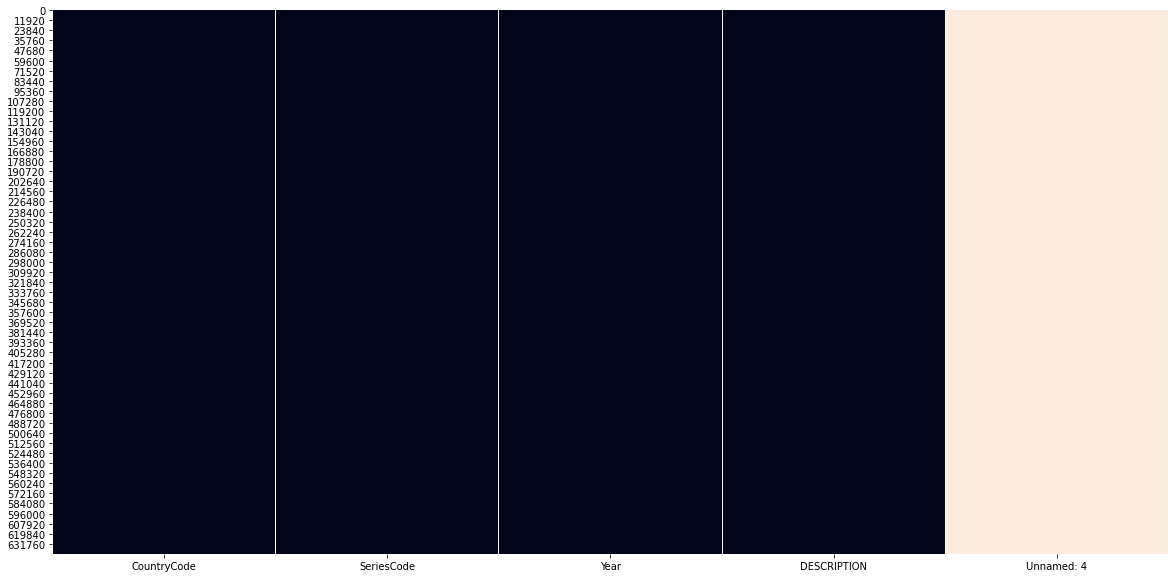

In [38]:
# Valeurs manquantes
outils.get_missing_values(foot_note, False, True)

In [39]:
# Doublon avec toutes les colonnes du dataframe
foot_note[foot_note.duplicated(keep=False)].shape[0];

In [40]:
# Doublons sur les 2 colonnes CountryCode et SeriesCode
doublons_deux = foot_note[foot_note.duplicated(['CountryCode', 'SeriesCode'], keep=False)]
print(f'Nombre de doublons code pays/indicateur: {doublons_deux.shape[0]}.')
doublons_deux;
# ==> Plusieurs années de référence pour un ou plusieurs code(s) indicateur(s) par code ISO-3166-alpha-3.

Nombre de doublons code pays/indicateur: 622238.


In [41]:
# Doublons sur la colonne CountryCode
doublons_1 = foot_note[foot_note.duplicated(['DESCRIPTION'], keep=False)]
print(doublons_1.shape)
foot_note['DESCRIPTION'].nunique()
# ==> Plusieurs description de l'incertitude, des exceptions, des modes de mise à jour des codes indicateurs par année par pays.

(635775, 5)


9102

In [42]:
# Le nombre de code ISO alpha 3 ne correspond pas au code ISO alpha 3 du jeu de données EdStatsCountry-Series.csv.
country['Country Code'].nunique() == foot_note['CountryCode'].nunique();

In [43]:
# Recherche des noms des pays n'apparaissant pas dans le jeu de données EdStatsCountry-Series.csv
country[~country['Country Code'].isin(foot_note['CountryCode'])][['Short Name']].sort_values(by = 'Short Name');
# ==> Les pays en plus dans le jeu de données EdStatsFootNote.csv sont des noms des pays devenus autonomes (Saint Martin, Groenland).

**Pays\Top 10 Code indicateur mis à jour - Top 10 des descriptions - Nombre de pays avec des mises à jour d'indicateur par années**

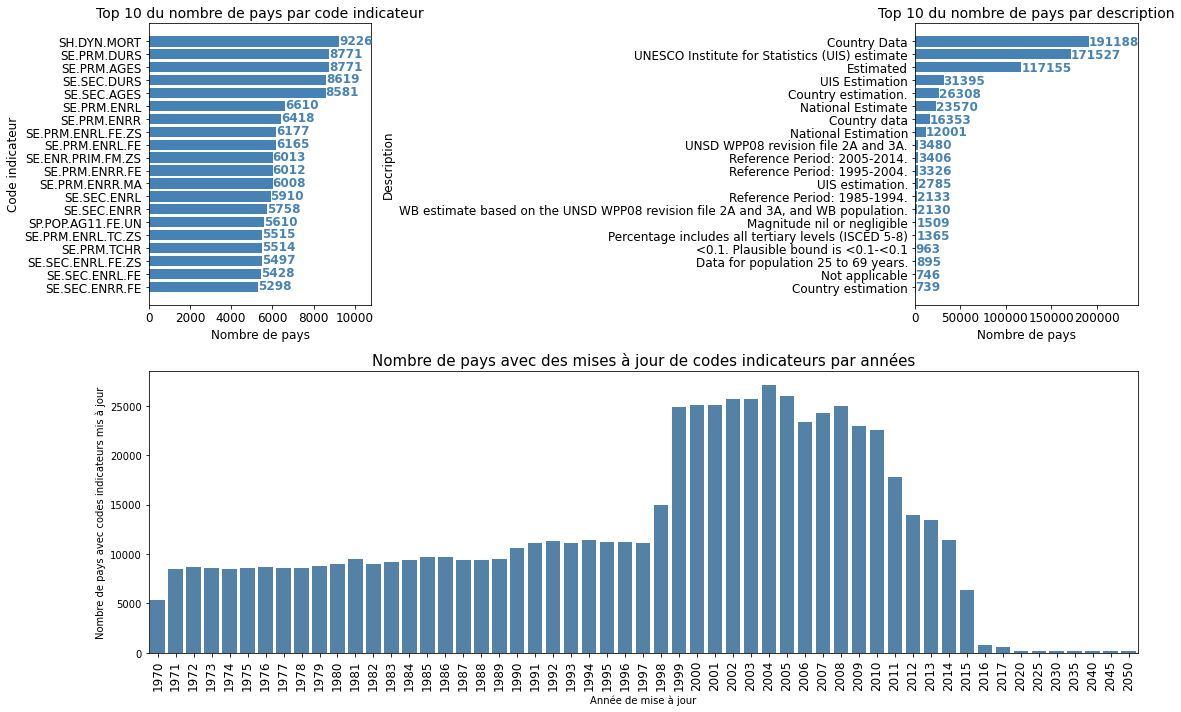

In [44]:
# Regroupement des pays par code indicateur et des pays par description

plt.figure(figsize=(16, 10))
G = gridspec.GridSpec(2, 2)

# Graphique ligne 1, colonne 1 ------------------
ax1 = plt.subplot(G[0, 0])
# Top 10 du nombre de pays par code indicateur
serie_code = foot_note.groupby('SeriesCode')[['CountryCode']].count().reset_index().sort_values(by='CountryCode')['SeriesCode'].tail(20)
nb_pays_par_serie_code=foot_note.groupby('SeriesCode')[['CountryCode']].count()['CountryCode'].sort_values().tail(20)
ax1.barh(y = serie_code, width=nb_pays_par_serie_code,color='SteelBlue')
for i, v in enumerate(nb_pays_par_serie_code):
    ax1.text(v + 3, i - .2, str(v), color='SteelBlue', fontweight='bold', fontsize='12')
ax1.set_title('Top 10 du nombre de pays par code indicateur', fontsize=14)
ax1.set_xlabel('Nombre de pays', fontsize='12')
ax1.set_ylabel('Code indicateur', fontsize='12')
ax1.tick_params(labelsize=12)
ax1.grid(False)
ax1.set_xlim([0, 10800])

# Graphique ligne 1, colonne 2 ------------------
ax2 = plt.subplot(G[0, 1])
# Top 10 du nombre de pays par description
description = foot_note.groupby('DESCRIPTION')[['CountryCode']].count().reset_index().sort_values(by='CountryCode')['DESCRIPTION'].tail(20)
nb_pays_par_description=foot_note.groupby('DESCRIPTION')[['CountryCode']].count()['CountryCode'].sort_values().tail(20)
ax2.barh(y = description, width=nb_pays_par_description, color='SteelBlue')
for i, v in enumerate(nb_pays_par_description):
    ax2.text(v + 10, i - .3, str(v), color='SteelBlue', fontweight='bold', fontsize='12')
ax2.set_title('Top 10 du nombre de pays par description', fontsize='14')
ax2.set_xlabel('Nombre de pays', fontsize='12')
ax2.set_ylabel('Description', fontsize='12')
ax2.tick_params(labelsize=12)
ax2.grid(False)
ax2.set_xlim([0, 245000])

# Graphique ligne 2, sur les 2 colonnes ------------------
ax3 = plt.subplot(G[1, :])
# Pour plus de lisibilité, transformer par exemple 'YR2001' en '2001'
foot_note['Annee']=[row[-4:] for row in foot_note['Year']]
# Nombre de pays avec des mises à jour d'indicateur par années
ax3.set_title('Nombre de pays avec des mises à jour de codes indicateurs par années', size=15)
ax3 = sns.barplot(y = 'CountryCode', x='Annee', data = foot_note.groupby('Annee').count().reset_index(), color='SteelBlue')
ax3.set_xticklabels(labels = foot_note.groupby('Annee').count().reset_index()['Annee'], rotation=90, size=12)
ax3.set_xlabel('Année de mise à jour')
ax3.set_ylabel('Nombre de pays avec codes indicateurs mis à jour')

plt.tight_layout()
plt.show()

Le nombre de mise à jour des indicateurs semble régulier entre 1970 à 1990, suivi d'une légère augmentation entre 1991 et 1997, une accélération entre 1998 et 2013 puis de nouveau une chute des mises à jour qui sont presques nulles en 2017 et entre 2020 et 2050 (les années de prédictions).

***
**Bilan sur le jeu de données EdStatsFootNote.csv** : 
***

- Le jeu de données contient les **années de références de mises à jour des indicateurs par pays** et la **description des incertitudes, exceptions**, remarques sur les mises à jour.
- Le jeu de données contient **643638 lignes et 5 colonnes**.
- Nombre de **valeurs manquantes** totales : 643638 NaN pour 3218190 données (**20.0 %** : variable Unnamed: 4).
- Plusieurs dates ou description de mise à jour pour chacun des indicateurs possibles par pays.

***
*Notes : à garder en mémoire si on utilise ce jeu de données*
***

- Les pays non présents dans le jeu de données EdStatsFootNote.csv mais présents dans le jeu de données EdStatsCountry-Series.csv sont : 
    - Saint Martin,
    - Groenland.
- La variable **Unnamed: 4** est vide, elle pourra être supprimée si le jeu de donnée est utilisé.

### <span style='background:PowderBlue'>2.4. Analyse du jeu de données EdStatsSeries.csv</span>

In [45]:
# Chargement du jeu de données
series = pd.read_csv('EdStatsSeries.csv', delimiter=',')

In [46]:
# Contenu des 3 premières lignes
series.head(3);

In [47]:
# Contenu des 3 dernières colonnes
series.tail(3);

In [48]:
# Nom des colonnes
series.columns.to_list();

In [49]:
# Résumé des variables qualitatives
series.describe(exclude=[np.number]);

In [50]:
# Résumé des variables quantitatives
series.describe();

In [51]:
# Taille : nombre de lignes/colonnes
nRow, nCol = series.shape
print(f'Le jeu de données contient {nRow} lignes et {nCol} colonnes.')

Le jeu de données contient 3665 lignes et 21 colonnes.


In [52]:
# Types des variables
# outils.get_types_variables(series, False, False, True)

Valeurs manquantes :55203 NaN pour 76965 données (71.72 %)
-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


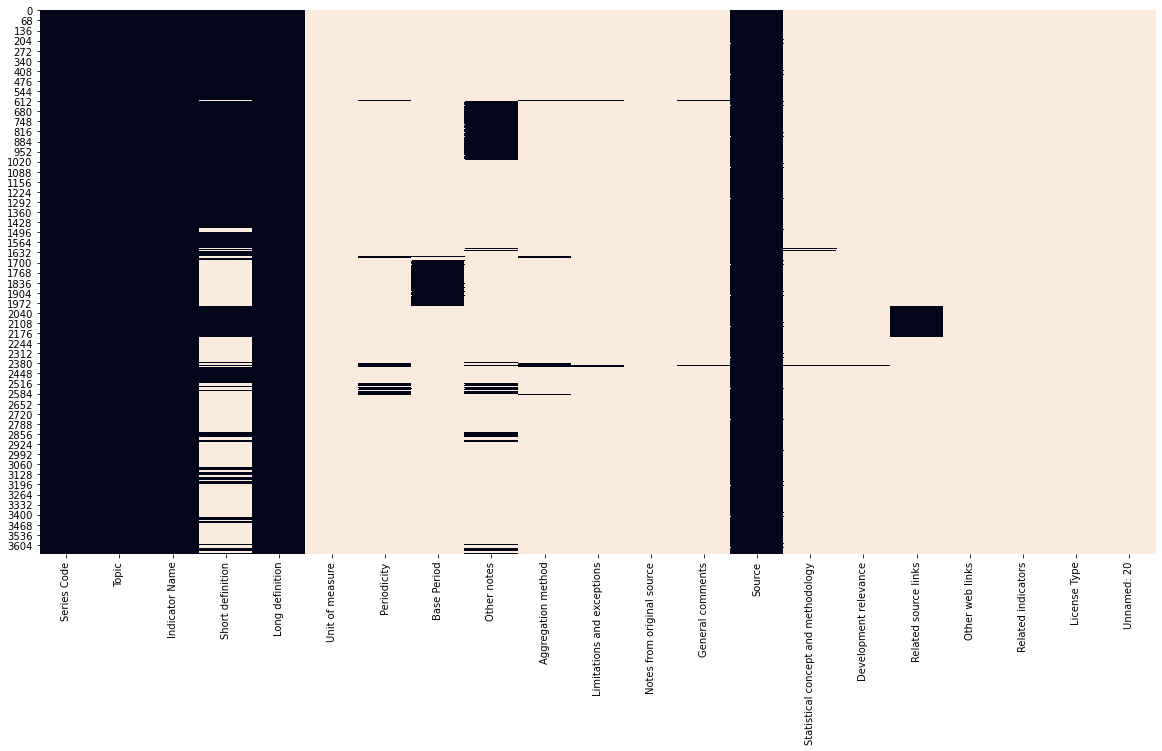

In [53]:
# Valeurs manquantes
outils.get_missing_values(series, False, True)

In [54]:
# Doublon avec toutes les colonnes du dataframe
series[series.duplicated(keep=False)].shape[0];

In [55]:
# Nombre de thèmes
unique=series['Topic'].nunique()
print(f'{unique} thèmes regroupant les indicateurs')

37 thèmes regroupant les indicateurs


**Codes indicateurs\ Top 10 thèmes \ Last 27 thèmes**

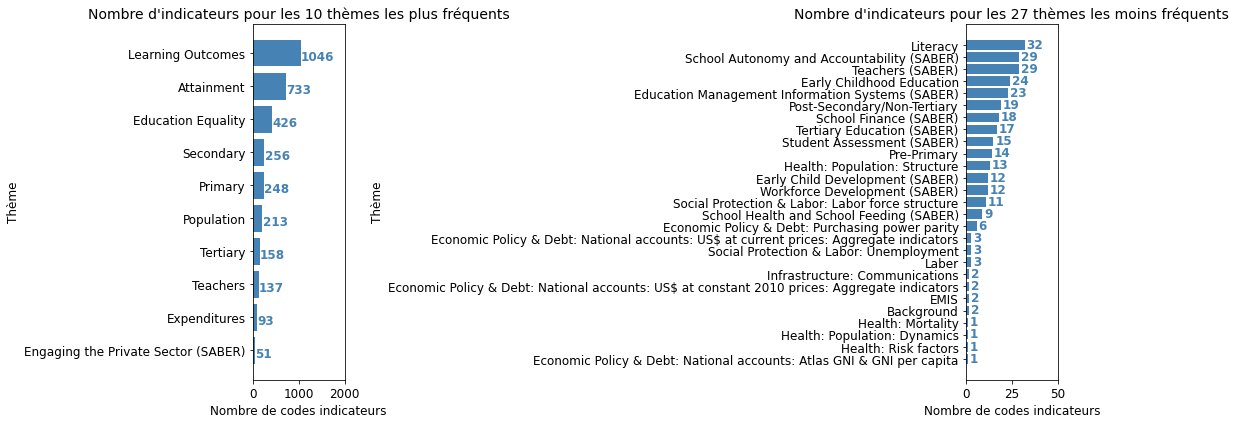

In [56]:
# Regroupement des pays par code indicateur et des pays par description

fig, ax = plt.subplots(1, 2, figsize=(15, 6))  

# Graphique ligne 1, colonne 1 ------------------
# Top 10 des thèmes les plus fréquents 
theme = series.groupby('Topic')[['Series Code']].count().reset_index().sort_values(by='Series Code')['Topic'].tail(10)
nb_code_par_theme=series.groupby('Topic')[['Series Code']].count()['Series Code'].sort_values().tail(10)
ax1=ax[0]
ax1.barh(y = theme, width=nb_code_par_theme, color='SteelBlue')
for i, v in enumerate(nb_code_par_theme):
    ax1.text(v + 3, i - .2, str(v), color='SteelBlue', fontweight='bold', fontsize=12)
ax1.set_title('Nombre d\'indicateurs pour les 10 thèmes les plus fréquents', fontsize=14)
ax1.set_xlabel('Nombre de codes indicateurs', fontsize=12)
ax1.set_ylabel('Thème', fontsize=12)
ax1.tick_params(labelsize=12)
ax1.grid(False)
ax1.set_xlim([0, 2000])

# Graphique ligne 1, colonne 2 ------------------
# last 27 thèmes les moins fréquents
theme_moins = series.groupby('Topic')[['Series Code']].count().reset_index().sort_values(by='Series Code')['Topic'].head(27)
nb_code_par_theme_moins=series.groupby('Topic')[['Series Code']].count()['Series Code'].sort_values().head(27)
ax2=ax[1]
ax2.barh(y = theme_moins, width=nb_code_par_theme_moins, color='SteelBlue')
for i, v in enumerate(nb_code_par_theme_moins):
    ax2.text(v + 1, i - .25, str(v), color='SteelBlue', fontweight='bold', fontsize=12)
ax2.set_title('Nombre d\'indicateurs pour les 27 thèmes les moins fréquents', fontsize=14)
ax2.set_xlabel('Nombre de codes indicateurs', fontsize=12)
ax2.set_ylabel('Thème', fontsize=12)
ax2.tick_params(labelsize=12)
ax2.grid(False)
ax2.set_xlim([0, 50])

fig.tight_layout()
plt.show()

In [57]:
# Extraction des nom courts et longs des indicateurs pour analyser EdStatsData.csv
df_tmp=series[['Series Code','Indicator Name', 'Short definition', 'Long definition']];
df_tmp.to_csv('Indicateurs.txt', header=True, index=None, sep=',', mode='w');

***
**Bilan sur le jeu de données EdStatsSeries.csv** : 
***

- Le jeu de données permet de connaître le **thème des indicateurs**, les **descriptions longues et les sources**. Il donne des informations sur les indicateurs socio-éduco-économique classés en 37 thèmes.
- Le jeu de données contient **3665 lignes et 21 colonnes**.
- Nombre de **valeurs manquantes** totales 55203 NaN pour 76965 données (**71.72 %**).
- Aucun doublon.	

***
*Notes : à garder en mémoire si on utilise ce jeu de données*
***

- Les 5 colonnes principales, le code indicateur, le nom, la description longue et la référence de l’indicateur sont 100% complètes.
- Le reste des variables est très peu renseigné (>85% de valeurs manquantes) et 6 variables sont complètement vides (donc à supprimer).

### <span style='background:PowderBlue'>2.5. Analyse du jeu de données EdStatsData.csv</span>

In [58]:
# Chargement du jeu de données
data = pd.read_csv('EdStatsdata.csv', delimiter=',', low_memory=False)

In [59]:
# 3 lignes au hasard
data.sample(3);

In [60]:
# Contenu des 3 premières lignes
data.head(3);

In [61]:
# Contenu des 3 dernières colonnes
data.tail(3);

In [62]:
# Nom des colonnes
data.columns;

In [63]:
# Résumé des variables qualitatives
data.describe(exclude=[np.number])

,Country Name,Country Code,Indicator Name,Indicator Code
count,886930,886930,886930,886930
unique,242,242,3665,3665
top,West Bank and Gaza,MWI,Government expenditure on education as % of GD...,PRJ.ATT.2039.S1.MF
freq,3665,3665,242,242


Autant de codes pays que de noms de pays et tous les indicateurs comportent un nom.

In [64]:
# Résumé des variables quantitatives
data.describe()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
count,7.22880e+04,3.55370e+04,3.56190e+04,3.55450e+04,3.57300e+04,8.73060e+04,3.74830e+04,3.75740e+04,3.75760e+04,3.68090e+04,8.91220e+04,3.87770e+04,3.75110e+04,3.84600e+04,3.86060e+04,9.02960e+04,3.93720e+04,3.86410e+04,3.85520e+04,3.75400e+04,1.24405e+05,7.44370e+04,7.55430e+04,7.57930e+04,7.74620e+04,1.31361e+05,7.68070e+04,7.34530e+04,8.49140e+04,1.18839e+05,1.76676e+05,1.23509e+05,1.24205e+05,1.30363e+05,1.28814e+05,1.84108e+05,1.40312e+05,1.37272e+05,1.34387e+05,1.42108e+05,2.42442e+05,1.46012e+05,1.47264e+05,1.37509e+05,1.13789e+05,1.31058e+05,1.64600e+04,143.00000,5.14360e+04,5.14360e+04,5.14360e+04,5.14360e+04,5.14360e+04,5.14360e+04,5.14360e+04,5.14360e+04,5.14360e+04,5.14360e+04,5.14360e+04,5.14360e+04,5.14360e+04,5.14360e+04,5.14360e+04,5.14360e+04,5.14360e+04,0.0
mean,1.97477e+09,4.25364e+09,4.59236e+09,5.10501e+09,5.40149e+09,2.31429e+09,5.73181e+09,6.12444e+09,6.67149e+09,7.43672e+09,3.28390e+09,7.66497e+09,7.91372e+09,7.85691e+09,8.11800e+09,3.62276e+09,9.15655e+09,1.01490e+10,1.10471e+10,1.19544e+10,9.08442e+09,1.57167e+10,1.60467e+10,1.64353e+10,1.68402e+10,1.05254e+10,1.87463e+10,2.02739e+10,1.79468e+10,1.33156e+10,9.42338e+09,1.38487e+10,1.42830e+10,1.44939e+10,1.58973e+10,1.18864e+10,1.68467e+10,1.87230e+10,2.02979e+10,1.89491e+10,1.18959e+10,2.11791e+10,2.17632e+10,2.42533e+10,2.67845e+10,2.35372e+10,1.93441e+11,2.16084,5.78070e+02,6.05477e+02,6.31592e+02,6.55652e+02,6.75152e+02,6.91129e+02,7.04064e+02,7.14579e+02,7.22487e+02,7.27129e+02,7.28378e+02,7.26648e+02,7.22833e+02,7.17690e+02,7.11307e+02,7.03427e+02,6.94030e+02,NaN
std,1.21169e+11,1.80481e+11,1.91408e+11,2.05917e+11,2.11215e+11,1.37506e+11,2.21555e+11,2.32549e+11,2.47399e+11,2.66096e+11,1.78077e+11,2.74414e+11,2.79055e+11,2.82381e+11,2.94063e+11,2.00293e+11,3.26467e+11,3.53535e+11,3.80426e+11,4.01487e+11,3.66567e+11,4.88136e+11,5.01206e+11,5.12196e+11,5.29298e+11,4.28522e+11,5.81259e+11,6.14236e+11,5.85915e+11,5.15347e+11,4.44237e+11,5.44924e+11,5.62289e+11,5.80361e+11,6.27834e+11,5.57618e+11,6.85148e+11,7.46569e+11,7.94413e+11,7.62365e+11,6.21871e+11,8.55585e+11,8.83395e+11,9.51302e+11,1.02318e+12,9.73246e+11,2.83919e+12,0.81058,1.47507e+04,1.57730e+04,1.67856e+04,1.77867e+04,1.87441e+04,1.96541e+04,2.05294e+04,2.13685e+04,2.21584e+04,2.28799e+04,2.35234e+04,2.40815e+04,2.45590e+04,2.49659e+04,2.53018e+04,2.55607e+04,2.57419e+04,NaN
min,-1.43556e+00,-1.59462e+00,-3.05652e+00,-4.03258e+00,-4.21356e+00,-3.65857e+00,-2.95094e+00,-3.17487e+00,-3.55875e+00,-2.97361e+00,-1.40424e+00,-1.47834e+00,-2.35876e+00,-2.86727e+00,-2.80055e+00,-2.21632e+00,-1.55672e+00,-1.41089e+00,-1.42520e+00,-1.56242e+00,-1.80375e+00,-5.81434e+00,-5.08933e+00,-6.18486e+00,-4.79269e+00,-2.69772e+00,-3.82017e+00,-2.51724e+00,-6.08620e+04,-6.52600e+04,-6.75930e+04,-6.97370e+04,-9.21430e+04,-1.11186e+05,-1.26260e+05,-1.34724e+05,-3.70894e+05,-3.88217e+05,-4.08854e+05,-4.56124e+05,-4.96905e+05,-5.70994e+05,-6.04993e+05,-6.15748e+05,-8.90000e+01,-2.46785e+00,-1.79754e+00,1.00000,-1.87000e+00,-2.00000e+00,-2.11000e+00,-2.15000e+00,-2.14000e+00,-2.09000e+00,-1.98000e+00,-1.83000e+00,-1.63000e+00,-1.44000e+00,-1.26000e+00,-1.09000e+00,-9.20000e-01,-7.80000e-01,-6.50000e-01,-5.50000e-01,-4.50000e-01,NaN
25%,8.90000e-01,8.85321e+00,9.24092e+00,9.59520e+00,9.86159e+00,1.40000e+00,9.31261e+00,9.51991e+00,1.00000e+01,1.00000e+01,1.77000e+00,9.46869e+00,9.98933e+00,9.58182e+00,9.06805e+00,2.15000e+00,9.33292e+00,9.59533e+00,9.71550e+00,9.67964e+00,4.83000e+00,5.13455e+01,4.93385e+01,4.94488e+01,4.78328e+01,5.20000e+00,4.83649e+01,5.51085e+01,3.34687e+01,1.74905e+01,5.69904e+00,1.59990e+01,1.58425e+01,1.55098e+01,1.41869e+01,5.72000e+00,1.27762e+01,1.26866e+

- Toutes les variables 'année' contiennent des données quantitatives exploitables.
- La variable **Unnamed: 69** est **vide** et devra être supprimée.

In [65]:
# Taille : nombre de lignes/colonnes
nRow, nCol = data.shape
print(f'Le jeu de données contient {nRow} lignes et {nCol} colonnes.')

Le jeu de données contient 886930 lignes et 70 colonnes.


,Nombre par type de variable,% des types de variable
float64,66,94.29000
object,4,5.71000


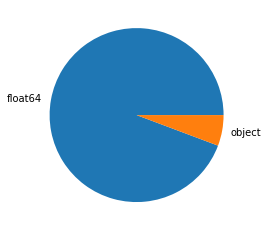

In [66]:
# Types de variable
outils.get_types_variables(data, False, True, True)

Valeurs manquantes :53455179 NaN pour 62085100 données (86.1 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
Unnamed: 69,886930,100.00000
2017,886787,99.98000
2016,870470,98.14000
1971,851393,95.99000
1973,851385,95.99000
1972,851311,95.98000
1974,851200,95.97000
1979,850121,95.85000
1982,849419,95.77000
1989,849390,95.77000


-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


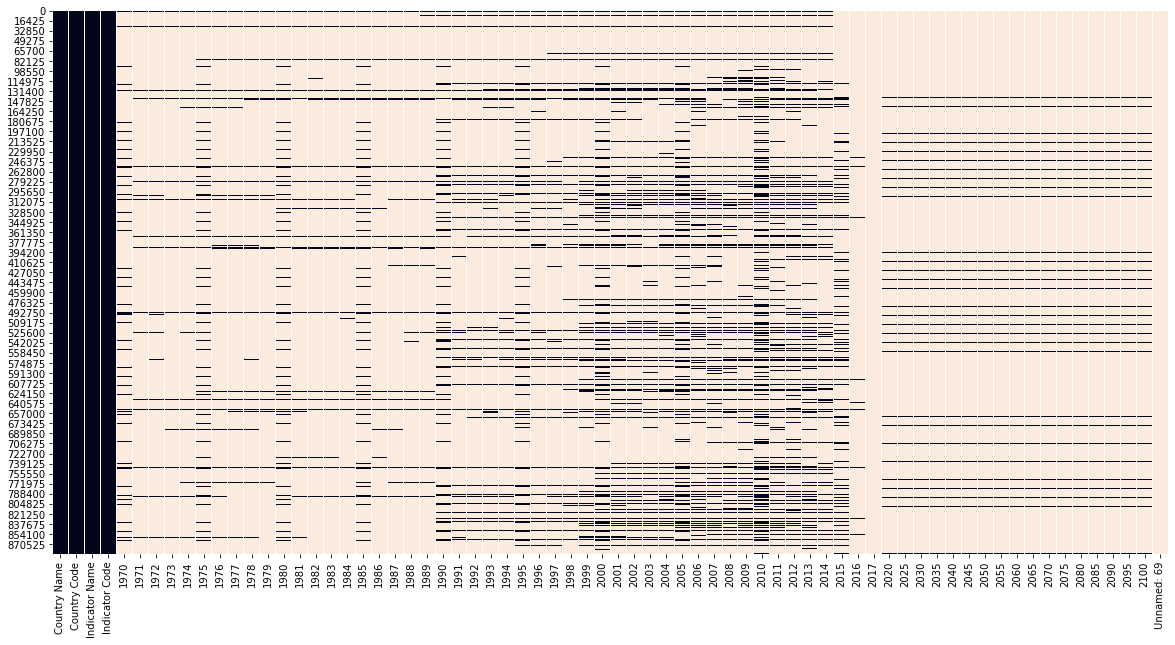

In [67]:
outils.get_missing_values(data, True, True)

Nombreuses valeurs manquantes (en saumon).

In [68]:
# Doublon avec toutes les colonnes du dataframe
data[data.duplicated(keep=False)].shape[0];

In [69]:
# Doublons sur les 2 colonnes Country Code et Indicator Code
data[data.duplicated(['Country Code', 'Indicator Code'], keep=False)].shape[0];

**Comparaison des pays présents dans EdStatsData.csv et EdStatsCountries.csv**

In [70]:
# Le nombre de code ISO alpha 3 ne correspond pas au code ISO alpha 3 du jeu de données EdStatsCountry.csv.
data['Country Code'].nunique() == country['Country Code'].nunique();

In [71]:
# Recherche du pays présent dansEdStatsData.csv mais pas dans EdStatsCountry-Series.csv
df_pays_plus=data[~data['Country Code'].isin(country['Country Code'])][['Country Name']]
df_pays_plus.drop_duplicates(inplace=True)
df_pays_plus;
# ==> Le pays en plus dans le jeu de données EdStatsData.csv est 'British Virgin Islands'.

**Comparaison des pays présents dans EdStatsData.csv et EdStatsCountries-Series.csv**

In [72]:
# Le nombre de code ISO alpha 3 ne correspond pas au code ISO alpha 3 du jeu de données EdStatsCountry-Series.csv.
data['Country Code'].nunique() == country_series['CountryCode'].nunique();

In [73]:
# Recherche du pays présent dansEdStatsData.csv mais n'apparaissant pas dans le jeu de données EdStatsCountry-Series.csv
df_pays_plus2=data[~data['Country Code'].isin(country_series['CountryCode'])][['Country Name']].sort_values(by = 'Country Name')
df_pays_plus2.drop_duplicates(inplace=True)
df_pays_plus2;
# ==> Les pays en plus dans le jeu de données EdStatsData.csv sont : des noms de région, ou des noms de regroupement de revenus 
# ou certains regroupement de pays (European Union, North America..) et certains pays devenus autonomes (Curaçao).

**Nombre de données par année / par décénnie**

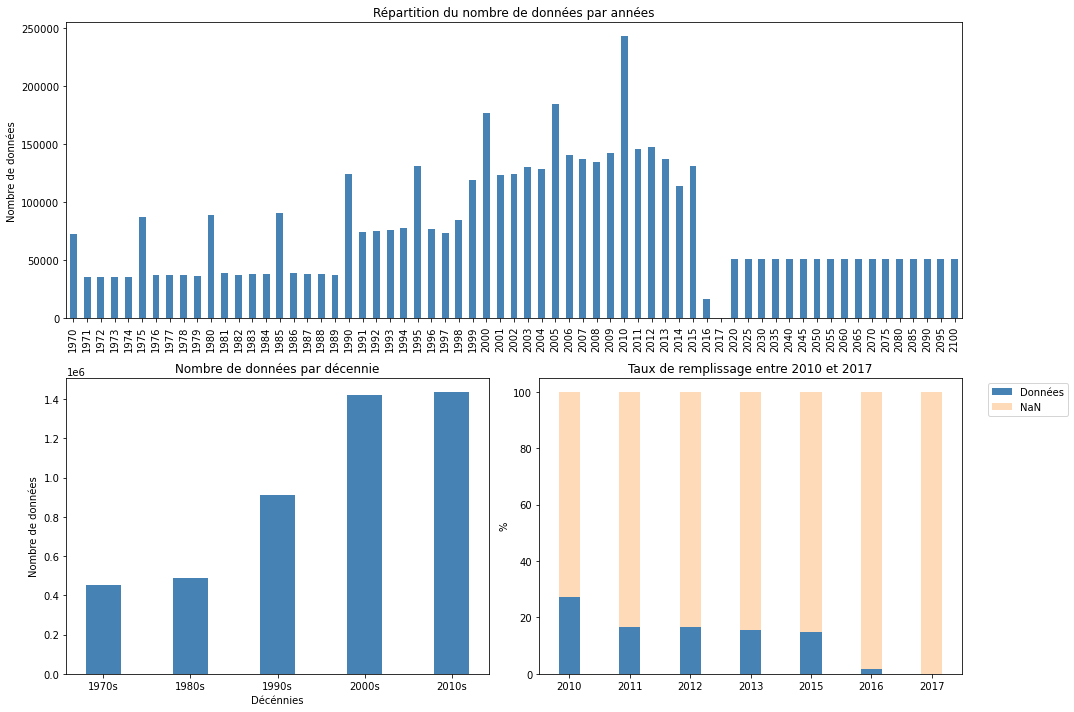

In [74]:
plt.figure(figsize=(15, 10))
G = gridspec.GridSpec(2, 2)

# Graphique ligne 1, sur les 2 colonnes ------------------
ax1 = plt.subplot(G[0, :])
# Répartition du nombre de données renseignées par années pour tous les indicateurs et tous les pays
present = data.loc[:,'1970':'2100'].notnull().sum()
ax1 = present.plot(kind='bar', color='SteelBlue')
ax1.set_title('Répartition du nombre de données par années')
ax1.set_ylabel('Nombre de données')
ax1.grid(False)

# Graphique ligne 2, colonne 1 ------------------
ax2 = plt.subplot(G[1, 0])
# Regroupement du nombre de données par décennie, les années 70, 80...
decade=data.loc[:,'1970':'2020'].copy().count()
ans=['1970s','1980s','1990s','2000s','2010s']
for i in range(5):
    j=i*10
    k=j+10
    decade[ans[i]]=decade[j:k,].sum()
# Affihage de la répartitions des données exploitables par décennie
width = 0.4   
ax2.bar(decade[ans].index, decade[ans].values, width, color='SteelBlue')
# ax2 = sns.barplot(y = decade[ans].values, x = decade[ans].index, color='SteelBlue')
ax2.set_xlabel('Décénnies')
ax2.set_ylabel('Nombre de données')
ax2.set_title('Nombre de données par décennie', size=12)
ax2.grid(False)

# Graphique ligne 2, colonne 2 ------------------
ax3 = plt.subplot(G[1, 1])
# Nombre de données totales
nb_tot=data.shape[0]
# Nombre de données non nulles par année de la décénnie 2010
annees=['2010','2011','2012','2013','2015','2016','2017']
nb_nonnul=data.copy()[annees].count()
df_2010s = pd.DataFrame({'annee':nb_nonnul.index, 'nb_nonnul':nb_nonnul.values})
# Taux de données non nulles par année de la décénnie 2010
df_2010s['%_nonnul']=round((df_2010s['nb_nonnul'])*100/nb_tot,2)
# Nombre de NaN par année de la décénnie 2010
df_2010s['%_nan']=round(100-df_2010s['%_nonnul'],2)
width = 0.35      
annes=df_2010s.index
taux_remplissage=df_2010s['%_nonnul']
taux_nan=df_2010s['%_nan']
ax3.bar(annees, taux_remplissage, width, label='Données', color='SteelBlue')
ax3.bar(annees, taux_nan, width, bottom=taux_remplissage, label='NaN', color='PeachPuff')
ax3.set_ylabel('%')
ax3.set_title('Taux de remplissage entre 2010 et 2017')
ax3.legend(bbox_to_anchor=(1.05, 1),loc = 2)
ax3.grid(False)

plt.tight_layout()
plt.show()

- On observe un pic de données tous les 5 ans.
- Les données sont doublées tous les 10 ans à partir de 1990.
- La dernière année exploitable est 2015.
- Les années 2020 à 2100 sont des années de prédiction.
- Les années 2010 sont les années avec le plus de données significatives et parmi cette décennie l'année 2010 est la plus fournie avec seulement 27% de données.
- Les années 2016 et 2017, les plus proches de l'année courante (2021) contiennent moins de 2 % de variables et sont donc inexploitables.

***
**Bilan sur le jeu de données EdStatsData.csv :** 
***

- Ce jeu de données donne l'**évolution de plusieurs indicateurs sur une période de 1970 à 2017 pour tous les pays du monde** et certaines **macros régions du monde**, avec des **prédictions** pour les années 2020 - 2100, il semble donc très **intéressant pour notre problématique**.
- Le jeu de données contient **886930 lignes et 70 colonnes**.
- Nombre de **valeurs manquantes** totales : 53455179 NaN pour 62085100 données possibles (**86.1 %**).
- Aucun doublon.
- Les années 2020 à 2010 sont des années de prédictions non exploitables pour notre mission.
- Les variables des code/nom des pays et des code/nom des indicateurs sont 100% complètes.
- Très peu de données sont exploitables sur la période 1970-1997 et 2016-2017 (>94% de valeurs manquantes).
- L'année comportant le maximum de données est l'année 2010 mais avec 27% de données seulement.
- L'année la moins renseignée est l'année 2017 (99,98% de valeurs manquantes) donc inexploitable.
- L'année 2015 est exploitable et est l'année la plus proche de l'année en cours (2021).

***
*Notes : à garder en mémoire si on utilise ce jeu de données*
***

- La variable 'Country Name' semble avoir des données autres que des noms de pays :
    - des noms de région, 
    - ou des noms de regroupement de revenus,
    - ou certains regroupement de pays (European Union, North America..)
  qui devront être nettoyées du jeu de données pour la pré-analyse.

### <span style='background:PowderBlue'>2.6. Conclusions sur les jeux de données</span>

- Ces jeux de données seront conservés pour la pré-analyse  :

    - ***EdStatsData.csv*** : qui contient la **target nom de pays** (= variable 'Country Name') et l'évolution des variables quantitatives des indicateurs par pays par années.
    - ***EdStatsCountry.csv*** : qui contient la **target nom de pays** (= variable 'Short Name') et les régions et les groupes de revenus permettant de faire des régroupements.

*Notes :*    
***

- Le jeu de données **EdStatsSeries.csv** contient le **thème des indicateurs et leurs descriptions longues** qui pourra être utile lors de la sélection des indicateurs pertinents.    

## <span style='background:Thistle'>3. Sélection des indicateurs pertinents</span>

<span style='background:PowderBlue'>**Réduction temporelle**</span>

D'après la description des données de EdStastsData.csv, la décénnie 2010 est la plus fournie en données sur la période 2010-2015 (plus de 94% de NaN pour 2016-2017).

- **Plage temporelle** retenue : **2010-2015**.    

In [75]:
cols_annees=data.columns[44:-20].tolist()

<span style='background:PowderBlue'>**Suppression des pays hors norme ISO-3166-alpha 3**</span>

In [76]:
# Recherche des codes pays des regroupements de pays
df_pays_en_trop=data[~data['Country Code'].isin(country_series['CountryCode'])][['Country Name','Country Code']].sort_values(by = 'Country Name')
df_pays_en_trop.drop_duplicates(inplace=True)
df_pays_en_trop
iso3_a_suppr=df_pays_en_trop['Country Code'].to_list()
iso3_a_suppr.remove('VGB')
iso3_a_suppr.remove('CUW')
iso3_a_suppr.remove('NRU')
iso3_a_suppr.remove('SXM')
iso3_a_suppr.remove('SSD')
iso3_a_suppr.remove('MAF')    
# df_pays=df_pays[~df_pays['Country Code'].isin(iso3_a_suppr)]
print(f'Pays hors norme ISO : {iso3_a_suppr}')

Pays hors norme ISO : ['ARB', 'EAS', 'EAP', 'EMU', 'ECS', 'ECA', 'EUU', 'HPC', 'HIC', 'LCN', 'LAC', 'LDC', 'LMY', 'LIC', 'LMC', 'MEA', 'MNA', 'MIC', 'NAC', 'OED', 'SAS', 'SSF', 'SSA', 'UMC', 'WLD']


**<span style='background:PowderBlue'>Réduction par seuil du taux de remplissage des 3665 indicateurs possibles</span>**

,count,mean,std,min,25%,50%,75%,max
TOT,3665.0,238.21801,303.89417,0.0,15.00,135.0,332.00,1278.00
%,3665.0,16.40712,20.92881,0.0,1.03,9.3,22.87,88.02


Qantile 80% : %    26.804
Qantile 90% : %    48.828


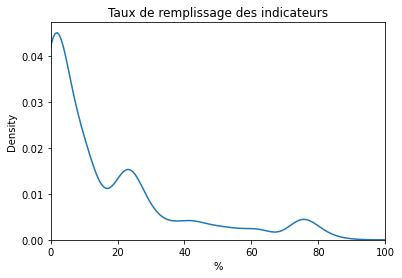

Indicateurs restants : 359


In [77]:
# -------------------------------------------------------------------------------------------------------------
# Répartition du nombre de données manquantes par années pour tous les indicateurs et tous les pays 
# -------------------------------------------------------------------------------------------------------------
# Dataframe de travail
df_taux_indicateurs = data.copy()
df_taux_indicateurs=df_taux_indicateurs[~df_taux_indicateurs['Country Code'].isin(iso3_a_suppr)]
# Compte le nombre de chaque indicateur par année
df_taux_indicateurs = df_taux_indicateurs.groupby('Indicator Code')[cols_annees].count()
df_taux_indicateurs=df_taux_indicateurs.reset_index()
# La variable 'TOT' est le nombre de données par indicateur pour tous les pays pour toutes les années.
df_taux_indicateurs['TOT']=df_taux_indicateurs[cols_annees].sum(axis=1)
# La variable '%' est le taux de remplissage de chaque indicateur pour tous les pays pour toutes les années.
# Chaque indicateur peut être associé à 242 pays pour chaque année (6 années) : 242*6=1452
df_taux_indicateurs['%']=round((df_taux_indicateurs['TOT'])*100/1452,2)
# Indicateurs statistiques
display(df_taux_indicateurs[['TOT','%']].describe().T)
quantile_80=df_taux_indicateurs[['%']].quantile(0.8).to_string()
print(f'Qantile 80% : {quantile_80}')
quantile_90=df_taux_indicateurs[['%']].quantile(0.9).to_string()
print(f'Qantile 90% : {quantile_90}')
# Analyse du taux de remplissage des indicateurs pour toutes les années pour trouver le seuil
sns.kdeplot(df_taux_indicateurs['%'])
plt.grid(False)
plt.xlim([0,100])
plt.title('Taux de remplissage des indicateurs')
plt.show()

df_indic_reduit=df_taux_indicateurs[df_taux_indicateurs['%']>50]
print(f'Indicateurs restants : {df_indic_reduit.shape[0]}')

Seulement 25% des indicateurs ont un taux de remplissage supérieur à 23%, et 10% des indicateurs ont un taux de remplissage supérieur à 48%.

**==> seuil de taux de remplissage des indicateurs fixés à 50% : il reste 359 indicateurs à analyser**.

<span style='background:PowderBlue'>**Recherche par mots clés correspondant à la cible**</span>

La cible de notre entreprise :
- la population des 15-24 ans, 
- le nombre d'étudiants scolarisés au niveau lycée et universités.
- le niveau de vie des habitants comparable par pays
- les moyens de communication (accès à l'électricité, accès au réseau internet, possession d'un ordinateur personnel).

En parcourant le site de la banque mondiale:

- les différents groupes d'indicateur à étudier sont :
    
    - **SE** : Social Education
    - **SP** : Social Population
    - **IT** : Infrastructure
    - **NY** : National Accounts, produits intérieurs et nationaux
    - **EG** : Energie

- les différents mots clés à rechercher :
    - **15** : pour la cible de la population des 15-19 ans
    - **20** : pour la cible de la population des 20-24 ans
    - **SEC** : pour les regroupements par lycéens
    - **TER** : pour les regroupements par étudiants de l'enseignement supérieur
    - **IT** : pour l'accès aux infrastructures techniques
    - **EG** : pour l'accès aux informations sur l'énergie

In [78]:
# Ajout du nom court de l'indicateur pour plus de compréhension
df_work_indic=series[['Series Code', 'Indicator Name','Topic','Long definition']]
df_work_indic.drop_duplicates(inplace=True)
df_indic_reduit = pd.merge(df_indic_reduit, df_work_indic, how='left', left_on='Indicator Code', right_on='Series Code')
df_indic_reduit.drop(columns=['Series Code'],inplace=True)

In [79]:
# Cible : lycéens 15-19 ans
pd.set_option('max_colwidth', None)
liste_mot_cle_15=[row for row in df_indic_reduit['Indicator Code'] if ('15') in row]
df_indic_reduit[df_indic_reduit['Indicator Code'].isin(liste_mot_cle_15)][['Indicator Code','Indicator Name','Topic','Long definition']]

,Indicator Code,Indicator Name,Topic,Long definition
140,SP.POP.1015.FE.UN,"Population, ages 10-15, female",Population,"Population, ages 10-15, female is the total number of females age 10-15."
141,SP.POP.1015.MA.UN,"Population, ages 10-15, male",Population,"Population, ages 10-15, male is the total number of males age 10-15."
142,SP.POP.1015.TO.UN,"Population, ages 10-15, total",Population,"Population, ages 10-15, total is the total population age 10-15."
152,SP.POP.1115.FE.UN,"Population, ages 11-15, female",Population,"Population, ages 11-15, female is the total number of females age 11-15."
153,SP.POP.1115.MA.UN,"Population, ages 11-15, male",Population,"Population, ages 11-15, male is the total number of males age 11-15."
154,SP.POP.1115.TO.UN,"Population, ages 11-15, total",Population,"Population, ages 11-15, total is the total population age 11-15."
164,SP.POP.1215.FE.UN,"Population, ages 12-15, female",Population,"Population, ages 12-15, female is the total number of females age 12-15."
165,SP.POP.1215.MA.UN,"Population, ages 12-15, male",Population,"Population, ages 12-15, male is the total number of males age 12-15."
166,SP.POP.1215.TO.UN,"Population, ages 12-15, total",Population,"Population, ages 12-15, total is the total population age 12-15."
194,SP.POP.1524.FE.UN,"Population, ages 15-24, female",Population,"Population, ages 15-24, female is the total number of females age 15-24."


Indicateur démographique retenu : **SP.POP.1524.TO.UN** Population, ages 15-24, total is the total population age 15-24

In [80]:
# Cible : universitaires 20-24 ans
liste_mot_cle_20=[row for row in df_indic_reduit['Indicator Code'] if ('20') in row]
df_indic_reduit[df_indic_reduit['Indicator Code'].isin(liste_mot_cle_20)][['Indicator Code','Indicator Name','Topic','Long definition']]

,Indicator Code,Indicator Name,Topic,Long definition
261,SP.POP.AG20.FE.UN,"Age population, age 20, female, UNESCO",Population,"Age population, female refers to female population at the specified age level, as estimated by the UNESCO Institute for Statistics."
262,SP.POP.AG20.MA.UN,"Population, age 20, male",Population,"Population, age 20, male refers to the male population at the specified age."
263,SP.POP.AG20.TO.UN,"Age population, age 20, total, UNESCO",Population,"Age population, total refers to total population at the specified age level, as estimated by the UNESCO Institute for Statistics."


Aucun indicateur retenu

In [81]:
# Cible : éducation lycée
liste_mot_cle_sec=[row for row in df_indic_reduit['Indicator Code'] if ('SEC') in row ]
df_indic_reduit[df_indic_reduit['Indicator Code'].isin(liste_mot_cle_sec)][['Indicator Code','Indicator Name','Topic','Long definition']]

,Indicator Code,Indicator Name,Topic,Long definition
16,SE.ENR.SECO.FM.ZS,"Gross enrolment ratio, secondary, gender parity index (GPI)",Secondary,"Ratio of female gross enrolment ratio for secondary to male gross enrolment ratio for secondary. It is calculated by dividing the female value for the indicator by the male value for the indicator. A GPI equal to 1 indicates parity between females and males. In general, a value less than 1 indicates disparity in favor of males and a value greater than 1 indicates disparity in favor of females."
50,SE.SEC.AGES,Official entrance age to lower secondary education (years),Secondary,"Age at which students would enter lower secondary education, assuming they had started at the official entrance age for the lowest level of education, had studied full-time throughout and had progressed through the system without repeating or skipping a grade."
51,SE.SEC.CMPT.LO.FE.ZS,"Lower secondary completion rate, female (%)",Secondary,"Total number of new female entrants in the last grade of lower secondary education, regardless of age, expressed as percentage of the total female population of the theoretical entrance age to the last grade of lower secondary. This indicator is also known as ""Gross intake rate to the last grade of lower secondary general education."" The ratio can exceed 100 percent due to over-aged and under-aged children who enter lower secondary school late/early and/or repeat grades. Data limitations preclude adjusting for students who drop out during the final year of lower secondary education. Thus this rate is a proxy that should be taken as an upper estimate of the actual lower secondary completion rate."
52,SE.SEC.CMPT.LO.MA.ZS,"Lower secondary completion rate, male (%)",Secondary,"Total number of new male entrants in the last grade of lower secondary education, regardless of age, expressed as percentage of the total male population of the theoretical entrance age to the last grade of lower secondary. This indicator is also known as ""Gross intake rate to the last grade of lower secondary general education."" The ratio can exceed 100 percent due to over-aged and under-aged children who enter lower secondary school late/early and/or repeat grades. Data limitations preclude adjusting for students who drop out during the final year of lower secondary education. Thus this rate is a proxy that should be taken as an upper estimate of the actual lower secondary completion rate."
53,SE.SEC.CMPT.LO.ZS,"Lower secondary completion rate, both sexes (%)",Secondary,"Total number of new entrants in the last grade of lower secondary education, regardless of age, expressed as percentage of the total population of the theoretical entrance age to the last grade of lower secondary. This indicator is also known as ""Gross intake rate to the last grade of lower secondary general education."" The ratio can exceed 100 percent due to over-aged and under-aged children who enter lower secondary school late/early and/or repeat grades. Data limitations preclude adjusting for students who drop out during the final year of lower secondary education. Thus this rate is a proxy that should be taken as an upper estimate of the actual lower secondary completion rate."
54,SE.SEC.DURS,Theoretical duration of secondary education (years),Secondary,Number of grades (years) in secondary education (ISCED 2 and 3).
55,SE.SEC.DURS.LO,NaN,NaN,NaN
56,SE.SEC.DURS.UP,Theoretical duration of upper secondary education (years),Secondary,Number of grades (years) in upper secondary education.
57,SE.SEC.ENRL,"Enrolment in secondary education, both sexes (number)",Secondary,Total number of students enrolled at public and private secondary education institutions regardless of age.
58,SE.SEC.ENRL.FE,"Enrolment in secondary education, female (number)",Secondary,Total number of female students enrolled at public and private secondary education institutions regardless of age.


Indicateur retenu : **SE.SEC.ENRR** taux brut de scolarisation dans le secondaire, pour les deux sexes (%) .

Nombre total d'inscriptions dans l'enseignement secondaire, quel que soit l'âge, exprimé en pourcentage de la population ayant l'âge officiel de fréquenter l'enseignement secondaire. Le TBS peut dépasser 100 % en raison de l'inclusion d'élèves trop âgés ou trop jeunes en raison d'une entrée précoce ou tardive à l'école et du redoublement.

In [82]:
# Cible : éducation enseignement supérieur
liste_mot_cle_ter=[row for row in df_indic_reduit['Indicator Code'] if ('TER') in row ]
df_indic_reduit[df_indic_reduit['Indicator Code'].isin(liste_mot_cle_ter)][['Indicator Code','Indicator Name','Topic','Long definition']]

,Indicator Code,Indicator Name,Topic,Long definition
17,SE.ENR.TERT.FM.ZS,"Gross enrolment ratio, tertiary, gender parity index (GPI)",Tertiary,"Ratio of female gross enrolment ratio for tertiary to male gross enrolment ratio for tertiary. It is calculated by dividing the female value for the indicator by the male value for the indicator. A GPI equal to 1 indicates parity between females and males. In general, a value less than 1 indicates disparity in favor of males and a value greater than 1 indicates disparity in favor of females."
78,SE.TER.ENRL,"Enrolment in tertiary education, all programmes, both sexes (number)",Tertiary,The total number of students enrolled at public and private tertiary education institutions.
79,SE.TER.ENRL.FE,"Enrolment in tertiary education, all programmes, female (number)",Tertiary,The total number of female students enrolled at public and private tertiary education institutions.
80,SE.TER.ENRL.FE.ZS,Percentage of students in tertiary education who are female (%),Tertiary,Number of female students at the tertiary education level (ISCED 5 to 8) expressed as a percentage of the total number of students (male and female) at the tertiary education level (ISCED 5 to 8) in a given school year.
81,SE.TER.ENRR,"Gross enrolment ratio, tertiary, both sexes (%)",Tertiary,"Total enrollment in tertiary education (ISCED 5 to 8), regardless of age, expressed as a percentage of the total population of the five-year age group following on from secondary school leaving."
82,SE.TER.ENRR.FE,"Gross enrolment ratio, tertiary, female (%)",Tertiary,"Total female enrollment in tertiary education (ISCED 5 to 8), regardless of age, expressed as a percentage of the total female population of the five-year age group following on from secondary school leaving."
83,SE.TER.ENRR.MA,"Gross enrolment ratio, tertiary, male (%)",Tertiary,"Total male enrollment in tertiary education (ISCED 5 to 8), regardless of age, expressed as a percentage of the total male population of the five-year age group following on from secondary school leaving."
303,SP.TER.TOTL.FE.IN,"Population of the official age for tertiary education, female (number)",Population,Female population of the age-group theoretically corresponding to tertiary education as indicated by theoretical entrance age and duration.
304,SP.TER.TOTL.IN,"Population of the official age for tertiary education, both sexes (number)",Population,Population of the age-group theoretically corresponding to tertiary education as indicated by theoretical entrance age and duration.
305,SP.TER.TOTL.MA.IN,"Population of the official age for tertiary education, male (number)",Population,Male population of the age-group theoretically corresponding to tertiary education as indicated by theoretical entrance age and duration.


Indicateur retenu : **SE.TER.ENRR** taux brut de scolarisation dans l'enseignement supérieur, pour les deux sexes (%).

Nombre total d'inscriptions dans l'enseignement supérieur (CITE 5 à 8), quel que soit l'âge, exprimé en pourcentage de la population totale du groupe d'âge de cinq ans suivant la fin de l'enseignement secondaire.

In [83]:
# Cible : moyen de communication internet
liste_mot_cle_it=[row for row in df_indic_reduit['Indicator Code'] if ('IT') in row ]
df_indic_reduit[df_indic_reduit['Indicator Code'].isin(liste_mot_cle_it)][['Indicator Code','Indicator Name','Topic','Long definition']]

,Indicator Code,Indicator Name,Topic,Long definition
0,IT.NET.USER.P2,Internet users (per 100 people),Infrastructure: Communications,"Internet users are individuals who have used the Internet (from any location) in the last 3 months. The Internet can be used via a computer, mobile phone, personal digital assistant, games machine, digital TV etc."


Indicateur retenu : **IT.NET.USER.P2** Utilisateurs d'Internet (pour 100 personnes).

Les internautes sont des personnes qui ont utilisé l'internet (de n'importe quel endroit) au cours des trois derniers mois. L'internet peut être utilisé via un ordinateur, un téléphone portable, un assistant numérique personnel, une machine de jeux, la télévision numérique, etc.

*Note :* Aucun indicateur sur la détention d'un ordinateur personnel.

In [84]:
# Cible : énergie, accès à l'éléctricité
liste_mot_cle_ene=[row for row in df_indic_reduit['Indicator Code'] if ('EG') in row ]
df_indic_reduit[df_indic_reduit['Indicator Code'].isin(liste_mot_cle_ene)][['Indicator Code','Indicator Name','Topic','Long definition']]

,Indicator Code,Indicator Name,Topic,Long definition


Aucun indicateur permettant de connaître les informations sur l'accès à l'électricité.

In [85]:
# Cible : économie
liste_mot_cle_eco=[row for row in df_indic_reduit['Indicator Code'] if ('NY') in row ]
df_indic_reduit[df_indic_reduit['Indicator Code'].isin(liste_mot_cle_eco)][['Indicator Code','Indicator Name','Topic','Long definition']]

,Indicator Code,Indicator Name,Topic,Long definition
1,NY.GDP.MKTP.CD,GDP (current US$),Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators,"GDP at purchaser's prices is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources. Data are in current U.S. dollars. Dollar figures for GDP are converted from domestic currencies using single year official exchange rates. For a few countries where the official exchange rate does not reflect the rate effectively applied to actual foreign exchange transactions, an alternative conversion factor is used."
2,NY.GDP.MKTP.KD,GDP (constant 2010 US$),Economic Policy & Debt: National accounts: US$ at constant 2010 prices: Aggregate indicators,"GDP at purchaser's prices is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources. Data are in constant 2010 U.S. dollars. Dollar figures for GDP are converted from domestic currencies using 2010 official exchange rates. For a few countries where the official exchange rate does not reflect the rate effectively applied to actual foreign exchange transactions, an alternative conversion factor is used."
3,NY.GDP.MKTP.PP.CD,"GDP, PPP (current international $)",Economic Policy & Debt: Purchasing power parity,PPP GDP is gross domestic product converted to international dollars using purchasing power parity rates. An international dollar has the same purchasing power over GDP as the U.S. dollar has in the United States. GDP is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources. Data are in current international dollars. For most economies PPP figures are extrapolated from the 2011 International Comparison Program (ICP) benchmark estimates or imputed using a statistical model based on the 2011 ICP. For 47 high- and upper middle-income economies conversion factors are provided by Eurostat and the Organisation for Economic Co-operation and Development (OECD).
4,NY.GDP.MKTP.PP.KD,"GDP, PPP (constant 2011 international $)",Economic Policy & Debt: Purchasing power parity,PPP GDP is gross domestic product converted to international dollars using purchasing power parity rates. An international dollar has the same purchasing power over GDP as the U.S. dollar has in the United States. GDP is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources. Data are in constant 2011 international dollars.
5,NY.GDP.PCAP.CD,GDP per capita (current US$),Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators,GDP per capita is gross domestic product divided by midyear population. GDP is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources. Data are in current U.S. dollars.
6,NY.GDP.PCAP.KD,GDP per capita (constant 2010 US$),Economic Policy & Debt: National accounts: US$ at constant 2010 prices: Aggregate indicators,GDP per capita is gross 

Indicateur retenu : **NY.GDP.PCAP.PP.CD** RNB par habitant, PPA ($ international actuel).
    
Généralement, les pays à revenu élevé ont des niveaux de prix plus élevés, tandis que les pays à faible revenu ont des niveaux de prix plus bas (effet Balassa-Samuelson). Les comparaisons entre pays basées sur les taux de change du marché pour les composantes du PIB liées aux dépenses reflètent à la fois les différences de production économique (volumes) et de prix. Étant donné les différences de niveaux de prix, la taille des pays à revenu élevé est gonflée, tandis que la taille des pays à faible revenu est réduite dans la comparaison. Les comparaisons entre pays basées sur les PPA du PIB au niveau de ses composantes de dépenses reflètent uniquement les différences de production économique (volume), car les PPA contrôlent les différences de niveau de prix entre les pays. Ainsi, la comparaison reflète la taille réelle des pays. 

In [86]:
# Taux de remplissage sur 2010-2015
indicateurs_retenus=['SP.POP.1524.TO.UN', 'SE.SEC.ENRR', 'SE.TER.ENRR', 'IT.NET.USER.P2', 'NY.GNP.PCAP.PP.CD']
mask=df_indic_reduit['Indicator Code'].isin(indicateurs_retenus)
cols=['Indicator Code','Indicator Name','%']
df_indic_reduit[mask][cols]

,Indicator Code,Indicator Name,%
0,IT.NET.USER.P2,Internet users (per 100 people),83.40
12,NY.GNP.PCAP.PP.CD,"GNI per capita, PPP (current international $)",76.58
68,SE.SEC.ENRR,"Gross enrolment ratio, secondary, both sexes (%)",57.02
81,SE.TER.ENRR,"Gross enrolment ratio, tertiary, both sexes (%)",51.72
196,SP.POP.1524.TO.UN,"Population, ages 15-24, total",74.79


<span style='background:PowderBlue'>**Bilan : indicateurs retenus**</span>

- démographique : 
    - **SP.POP.1524.TO.UN**
- économique : 
    - **NY.GNP.PCAP.PP.CD** 
- éducation : 
    - **SE.SEC.ENRR** 
    - **SE.TER.ENRR**
- numérique : 
    - **IT.NET.USER.P2** 

## <span style='background:Thistle'>4. Réduction du jeu de données</span>

Le jeu de données EdStatsData.csv comporte les indications chiffrées par année par indicateur par pays. Il constituera notre jeu de donnée de base. On se base sur le bilan de ce jeu de données analyser au chapitre '2' pour nettoyer/réduire le jeu de données.

<span style='background:PowderBlue'>**Suppression de la variable 'Unnamed: 69' vide**</span> 

In [87]:
# dataframe pour l'analyse des indicateurs par pays sans prédictions
df_pays=data.copy()
df_pays.drop(columns=['Unnamed: 69'],inplace=True)
df_pays.shape;
print(f'Nombre de lignes à l\'origine : {df_pays.shape[0]}')

Nombre de lignes à l'origine : 886930


<span style='background:PowderBlue'>**Réduction temporelle**</span>

D'après la description des données de EdStastsData.csv, la décénnie 2010 est la plus fournie en données sur la période 2010-2015 (plus de 94% de NaN pour 2016-2017) : **Plage temporelle** retenue : **2010-2015**.    

In [88]:
cols_a_supr=data.columns[4:44].to_list()
cols_a_supr.extend(data.columns[50:-1].to_list())
df_pays.drop(columns=cols_a_supr,inplace=True)

<span style='background:PowderBlue'>**Filtre avec les indicateurs pertinents**</span>

In [89]:
# Liste des indicateurs pertinents à conserver
indicateurs_a_garder=['SP.POP.1524.TO.UN','SE.SEC.ENRR','SE.TER.ENRR','IT.NET.USER.P2','IT.CMP.PCMP.P2','NY.GNP.PCAP.PP.CD']
# On ne conserve que les lignes donnant des informations sur les indicateurs retenus
df_pays=df_pays[df_pays['Indicator Code'].isin(indicateurs_a_garder)]
print(f'Nombre de lignes restantes : {df_pays.shape[0]}')

Nombre de lignes restantes : 1452


<span style='background:PowderBlue'>**Suppression des pays hors regroupement et des groupes de revenus**</span>

In [90]:
# Recherche des codes pays des regroupements de pays
df_pays_en_trop=df_pays[~df_pays['Country Code'].isin(country_series['CountryCode'])][['Country Name','Country Code']].sort_values(by = 'Country Name')
df_pays_en_trop.drop_duplicates(inplace=True)
iso3_a_suppr=df_pays_en_trop['Country Code'].to_list()
iso3_a_suppr.remove('VGB')
iso3_a_suppr.remove('CUW')
iso3_a_suppr.remove('NRU')
iso3_a_suppr.remove('SXM')
iso3_a_suppr.remove('SSD')
iso3_a_suppr.remove('MAF')    
df_pays=df_pays[~df_pays['Country Code'].isin(iso3_a_suppr)]
ng_lignes=df_pays.shape[0]
print(f'Nombre de lignes restantes : {ng_lignes}')

Nombre de lignes restantes : 1302


<span style='background:PowderBlue'>**Suppression des indicateurs des pays avec aucune donnée pour toutes les années**</span>

Les 4 premières variables sont 100% renseignées ==> thresh=4+1 pour conserver une des années avec au moins un chiffre significatif

In [91]:
df_pays.dropna(thresh = 5, inplace=True)
pourc_rgpt_non_chiffre=round(((ng_lignes-df_pays.shape[0])*100)/ng_lignes,2)
print(f'% de lignes sans indicateurs chiffrés supprimées : {pourc_rgpt_non_chiffre}')
print(f'Nombre de lignes restantes : {df_pays.shape[0]}')

% de lignes sans indicateurs chiffrés supprimées : 29.65
Nombre de lignes restantes : 916


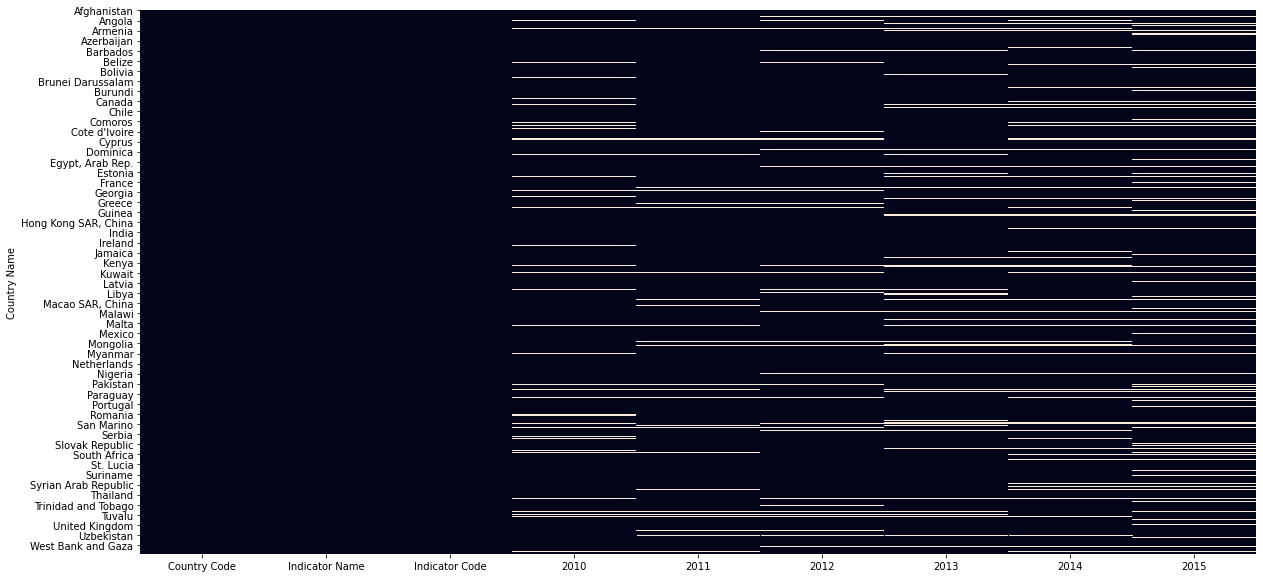

In [92]:
plt.figure(figsize=(20,10))
df_tmp=df_pays.set_index('Country Name')
sns.heatmap(df_tmp.isna(), cbar=False)
plt.show()  

## <span style='background:Thistle'>5. Fusion des données nécessaires des différents datasets</span>

Ajout des variables **Région** et **Groupe de revenus** au jeu de données de base. Ces variables nous permettront d'effectuer des statistiques et des graphiques pour les différentes régions ou les groupes de revenus.

In [93]:
# Variable 'Region' et 'Income Group' du jeu de données EdStatsCountry.csv en supprimant les données dupliquées
countries_income = pd.DataFrame({'Country_Code' : country['Country Code'].unique(), 
                                 'Region' : country['Region'], 
                                 'Income Group' : country['Income Group']})
df_pays = pd.merge(df_pays,countries_income, left_on='Country Code', right_on='Country_Code', how='left')
df_pays.drop(columns=['Country_Code'],inplace=True)
df_pays.columns;

**Régions 'NaN'**

In [94]:
df_pays['Region'].unique()

array(['South Asia', 'Europe & Central Asia',
       'Middle East & North Africa', 'Sub-Saharan Africa',
       'Latin America & Caribbean', 'East Asia & Pacific',
       'North America', nan, 'A Completer'], dtype=object)

In [95]:
df_pays[df_pays['Region'].isna()]

,Country Name,Country Code,Indicator Name,Indicator Code,2010,2011,2012,2013,2014,2015,Region,Income Group
117,British Virgin Islands,VGB,"Gross enrolment ratio, secondary, both sexes (%)",SE.SEC.ENRR,101.6024,96.24625,97.60359,98.3093,97.73733,98.73356,NaN,NaN
118,British Virgin Islands,VGB,"Gross enrolment ratio, tertiary, both sexes (%)",SE.TER.ENRR,NaN,NaN,NaN,NaN,NaN,41.64149,NaN,NaN


In [96]:
# Le pays British Virgin Islands appartient à la région 'Latin America & Caribbean'
df_pays.loc[[117, 118], 'Region'] = ['Latin America & Caribbean', 'Latin America & Caribbean']

**Groupes de revenus 'NaN'**

In [97]:
df_pays['Income Group'].unique()

array(['Low income', 'Upper middle income', 'High income: nonOECD',
       'Lower middle income', 'High income: OECD', nan, 'A Completer'],
      dtype=object)

In [98]:
df_pays[df_pays['Income Group'].isna()]

,Country Name,Country Code,Indicator Name,Indicator Code,2010,2011,2012,2013,2014,2015,Region,Income Group
117,British Virgin Islands,VGB,"Gross enrolment ratio, secondary, both sexes (%)",SE.SEC.ENRR,101.6024,96.24625,97.60359,98.3093,97.73733,98.73356,Latin America & Caribbean,NaN
118,British Virgin Islands,VGB,"Gross enrolment ratio, tertiary, both sexes (%)",SE.TER.ENRR,NaN,NaN,NaN,NaN,NaN,41.64149,Latin America & Caribbean,NaN


In [99]:
# Le pays British Virgin Islands appartient au groupe de revenus 'High income: nonOECD'
df_pays.loc[[117, 118], 'Income Group'] = ['High income: nonOECD', 'High income: nonOECD']

## <span style='background:Thistle'>6. Analyse des indicateurs retenus</span>

In [100]:
# Propagation des valeurs non nulles de 2010 vers 2015 pour travailler sur dernière valeur connue non nulle la plus récente en 2015
df_pays_fillna=df_pays.copy()
cols_to_interpolate=df_pays_fillna.columns[4:-2].tolist()
#  Variables quantitatives
df_numeric = df_pays_fillna[cols_to_interpolate]
# Variables qualitatives
df_categ = df_pays_fillna.loc[:, ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', 'Income Group', 'Region']]
df_numeric.fillna(method='ffill', axis=1, inplace=True)
df_pays_fillna = pd.concat([df_categ, df_numeric], axis=1)
nb_pays=df_pays_fillna['Country Name'].nunique()
print(f'Nombre de pays : {nb_pays}')
# On ne conserve que la dernière année totalement remplie : 2015
df_pays_1an=df_pays_fillna[['Country Name','Country Code','Indicator Name','Indicator Code', 'Region', 
                       'Income Group','2015']]
# # Dernière colonne remplie renommée en 'Last info'
df_pays_1an.rename(columns={'2015': 'Last info'}, inplace=True)
# # La méthode fillna transforme tous les types en object ==> retransformer la dernière colonne en numérique
df_pays_1an=df_pays_1an.astype({'Last info': 'float64'})
df_pays_1an;

Nombre de pays : 210


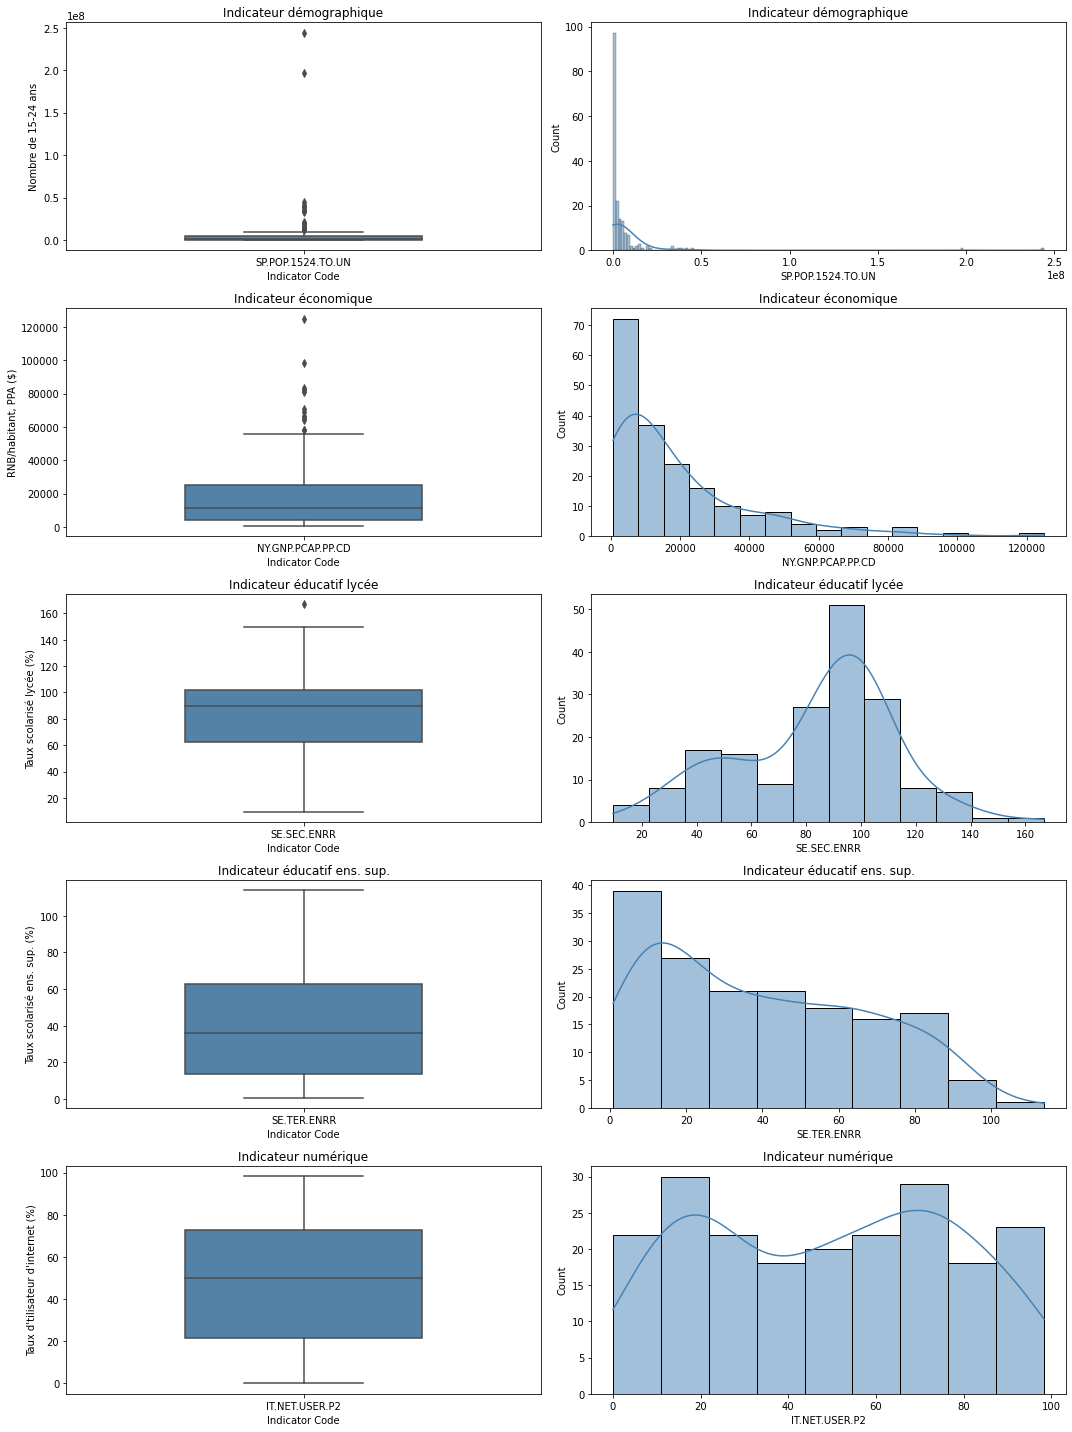

In [101]:
#Graphiques statistiques sur les 3 indicateurs  
plt.figure(figsize = (15, 20))

# ------------------------------------------------------------------------------------
# Indicateur démographique : SP.POP.1524.TO.UN
# ------------------------------------------------------------------------------------
df_pop=df_pays_1an[df_pays_1an['Indicator Code'] == 'SP.POP.1524.TO.UN']

plt.subplot(5,2,1)
sns.boxplot( x=df_pop['Indicator Code'], y=df_pop['Last info'], width=0.5, color='SteelBlue')
plt.title('Indicateur démographique')
plt.ylabel('Nombre de 15-24 ans')

plt.subplot(5,2,2)
sns.histplot(df_pop['Last info'], kde = True, color='SteelBlue')
plt.title('Indicateur démographique')
plt.xlabel('SP.POP.1524.TO.UN')

# ------------------------------------------------------------------------------------
# Indicateur économique : NY.GNP.PCAP.PP.CD
# ------------------------------------------------------------------------------------
df_eco=df_pays_1an[df_pays_1an['Indicator Code'] == 'NY.GNP.PCAP.PP.CD']

plt.subplot(5,2,3)
sns.boxplot( x=df_eco['Indicator Code'], y=df_eco['Last info'], width=0.5, color='SteelBlue')
plt.title('Indicateur économique')
plt.ylabel('RNB/habitant, PPA ($)')

plt.subplot(5,2,4)
sns.histplot(df_eco['Last info'], kde = True, color='SteelBlue')
plt.title('Indicateur économique')
plt.xlabel('NY.GNP.PCAP.PP.CD')

# ------------------------------------------------------------------------------------
# Indicateur éducatif lycée : SE.SEC.ENRR
# ------------------------------------------------------------------------------------
df_edu_sec=df_pays_1an[df_pays_1an['Indicator Code'] == 'SE.SEC.ENRR']

plt.subplot(5,2,5)
sns.boxplot( x=df_edu_sec['Indicator Code'], y=df_edu_sec['Last info'], width=0.5, color='SteelBlue')
plt.title('Indicateur éducatif lycée')
plt.ylabel('Taux scolarisé lycée (%)')

plt.subplot(5,2,6)
sns.histplot(df_edu_sec['Last info'], kde = True, color='SteelBlue')
plt.title('Indicateur éducatif lycée')
plt.xlabel('SE.SEC.ENRR')

# ------------------------------------------------------------------------------------
# Indicateur éducatif lycée : SE.TER.ENRR
# ------------------------------------------------------------------------------------
df_edu_ter=df_pays_1an[df_pays_1an['Indicator Code'] == 'SE.TER.ENRR']

plt.subplot(5,2,7)
sns.boxplot( x=df_edu_ter['Indicator Code'], y=df_edu_ter['Last info'], width=0.5, color='SteelBlue')
plt.title('Indicateur éducatif ens. sup.')
plt.ylabel('Taux scolarisé ens. sup. (%)')

plt.subplot(5,2,8)
sns.histplot(df_edu_ter['Last info'], kde = True, color='SteelBlue')
plt.title('Indicateur éducatif ens. sup.')
plt.xlabel('SE.TER.ENRR')

# ------------------------------------------------------------------------------------
# Indicateur numérique : SE.TER.ENRR
# ------------------------------------------------------------------------------------
df_num=df_pays_1an[df_pays_1an['Indicator Code'] == 'IT.NET.USER.P2']

plt.subplot(5,2,9)
sns.boxplot( x=df_num['Indicator Code'], y=df_num['Last info'], width=0.5, color='SteelBlue')
plt.title('Indicateur numérique')
plt.ylabel('Taux d\'tilisateur d\'internet (%)')

plt.subplot(5,2,10)
sns.histplot(df_num['Last info'], kde = True, color='SteelBlue')
plt.title('Indicateur numérique')
plt.xlabel('IT.NET.USER.P2')

plt.tight_layout()

*Notes :*
***

- Le taux de scolarisation dans l'enseignement supérieur est plus inégal entre les pays que le taux de scolarisation au niveau lycée.
- Pour l'indicateur numérique, forme bimodale, on distingue 3 groupes de pays répartis autour de 20%, 65% et 85%.
- Présence d'outliers pour les indicateurs démographique, économique et éducatif au niveau lycée.    

In [102]:
# Statistiques descriptives
mean_num=df_num['Last info'].mean()
mean_eco=df_eco['Last info'].mean()
mean_edu_sec=df_edu_sec['Last info'].mean()
mean_edu_ter=df_edu_ter['Last info'].mean()
mean_pop=df_pop['Last info'].mean()

median_num=df_num['Last info'].median()
median_eco=df_eco['Last info'].median()
median_edu_sec=df_edu_sec['Last info'].median()
median_edu_ter=df_edu_ter['Last info'].median()
median_pop=df_pop['Last info'].median()

var_num=df_num['Last info'].var(ddof=0)
var_eco=df_eco['Last info'].var(ddof=0)
var_edu_sec=df_edu_sec['Last info'].var(ddof=0)
var_edu_ter=df_edu_ter['Last info'].var(ddof=0)
var_pop=df_pop['Last info'].var(ddof=0)

std_num=df_num['Last info'].std(ddof=0)
std_eco=df_eco['Last info'].std(ddof=0)
std_edu_sec=df_edu_sec['Last info'].std(ddof=0)
std_edu_ter=df_edu_ter['Last info'].std(ddof=0)
std_pop=df_pop['Last info'].std(ddof=0)

skew_num=df_num['Last info'].skew()
skew_eco=df_eco['Last info'].skew()
skew_edu_sec=df_edu_sec['Last info'].skew()
skew_edu_ter=df_edu_ter['Last info'].skew()
skew_pop=df_pop['Last info'].skew()

kurtosis_num=df_num['Last info'].kurtosis()
kurtosis_eco=df_eco['Last info'].kurtosis()
kurtosis_edu_sec=df_edu_sec['Last info'].kurtosis()
kurtosis_edu_ter=df_edu_ter['Last info'].kurtosis()
kurtosis_pop=df_pop['Last info'].kurtosis()

data_stats = [['mean',mean_num, mean_eco, mean_edu_sec, mean_edu_ter, mean_pop],
        ['median', median_num, median_eco, median_edu_sec,median_edu_ter,median_pop],
        ['var',var_num, var_eco, var_edu_sec,var_edu_ter,var_pop], 
        ['std',std_num, std_eco,std_edu_sec, std_edu_ter, std_pop], 
        ['skew', skew_num, skew_eco, skew_edu_sec, skew_edu_ter, skew_pop], 
        ['kurtosis', kurtosis_num, kurtosis_eco, kurtosis_edu_sec, kurtosis_edu_ter, kurtosis_pop]]
df_stat = pd.DataFrame(data_stats,columns=['Desc','Stat_num','Stat_eco','Stat_edu_sec','Stat_edu_ter','Stat_pop'])
df_stat

,Desc,Stat_num,Stat_eco,Stat_edu_sec,Stat_edu_ter,Stat_pop
0,mean,48.63017,1.90438e+04,83.82360,39.49392,6.65499e+06
1,median,50.21966,1.16450e+04,89.88169,36.22854,1.33104e+06
2,var,811.61123,4.28604e+08,815.06711,775.82922,5.74750e+14
3,std,28.48879,2.07028e+04,28.54938,27.85371,2.39739e+07
4,skew,-0.00535,1.96926e+00,-0.35019,0.41960,8.28032e+00
5,kurtosis,-1.26904,4.77319e+00,-0.10257,-1.00113,7.43375e+01


- Les courbes des indicateurs démographiques et économique sont étalées à droite (skewness positif), moins aplaties que la distribution normale (kurtosis empirique positif, observations plus concentrée, leur variance est élevée.
- La courbe de l'indicateur éducatif du niveau lycée est bimodale, étalée à gauche (skewness négatif), plus aplatie que la distribution normale (kurtosis empirique négatif).
- La courbe de l'indicateur éducatif de l'enseignement supérieur est bimodale, étalée à droite (skewness positif), plus aplatie que la distribution normale (kurtosis empirique négatif).  
- La courbe de l'indicateur numérique est bimodale et plus aplatie que la distribution normale (kurtosis empirique négatif).

## <span style='background:Thistle'>7. Score</span>

<span style='background:PowderBlue'>**Imputation des valeurs manquantes**</span>

In [103]:
# Interpolation des valeurs par régression linéaire
df_interpolna=df_pays.copy()
cols_to_interpolate=df_interpolna.columns[4:-2].tolist()
#  Variables quantitatives
df_numeric = df_interpolna[cols_to_interpolate]
# Variables qualitatives
df_categ = df_interpolna.loc[:, ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', 'Income Group', 'Region']]
df_numeric.interpolate(method='linear', axis=1, inplace=True)
df_pays_all = pd.concat([df_categ, df_numeric], axis=1)
nb_pays=df_pays_all['Country Name'].nunique()
print(f'nombre de pays : {nb_pays}')

nombre de pays : 210


<span style='background:PowderBlue'>**Constitution du dataframe pour établir un score**</span>

In [104]:
# on ne conserve que les 5 indicateurs avec, pour chaque indicateur et pays, la dernière information réelle ou interpolée de 2015
df_score= df_pays_all.pivot_table(index=['Country Name'], columns="Indicator Code")['2015']
df_score.shape;

<span style='background:PowderBlue'>**Indicateurs manquants par pays**</span>

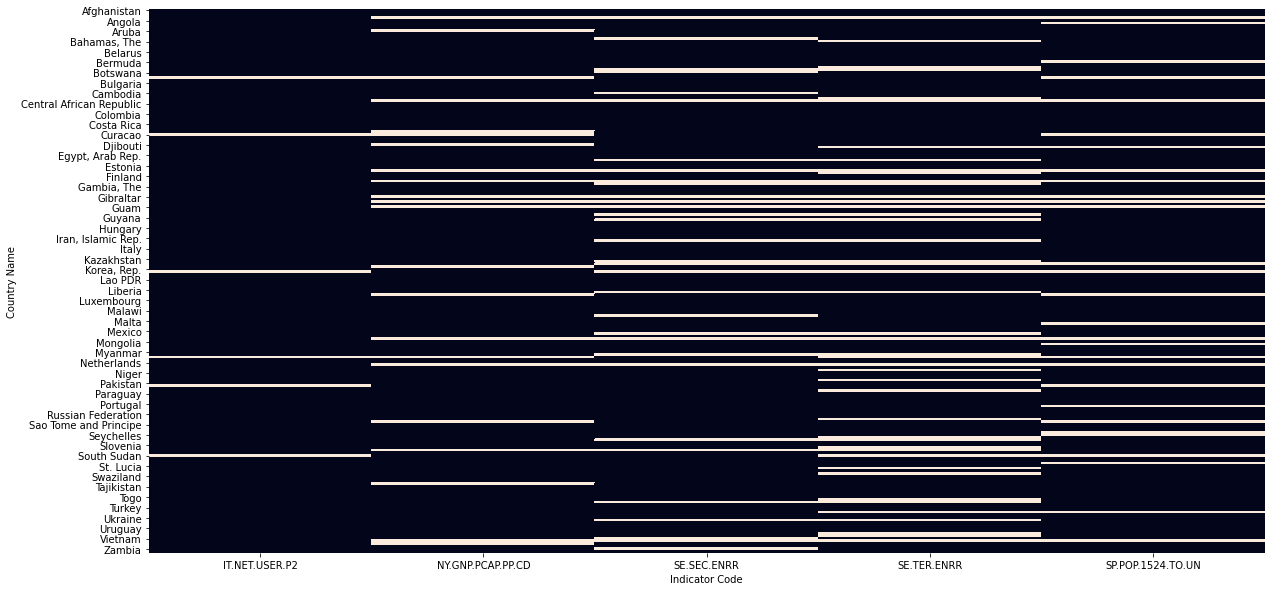

In [105]:
plt.figure(figsize=(20,10))
sns.heatmap(df_score.isna(), cbar=False)
plt.show()  

In [106]:
# Liste des pays avec au moins un indicateur manquant
s_pays_indic_manquant=df_score.notnull().sum(axis=1)
i_pays_indic_manquant=s_pays_indic_manquant[s_pays_indic_manquant<5].index
print(f'Nombre de pays à retirer : {len(i_pays_indic_manquant)}')
df_pays_retires=df_score.loc[i_pays_indic_manquant, :].sort_values(by='SP.POP.1524.TO.UN', ascending=False)
df_pays_retires

Nombre de pays à retirer : 70


Indicator Code,IT.NET.USER.P2,NY.GNP.PCAP.PP.CD,SE.SEC.ENRR,SE.TER.ENRR,SP.POP.1524.TO.UN
Country Name,,,,,
Vietnam,43.50000,5740.0,NaN,28.83565,16939813.0
Kenya,21.00000,2990.0,NaN,NaN,8902971.0
Iraq,17.22000,15810.0,NaN,NaN,7340940.0
"Venezuela, RB",61.86925,17440.0,89.66401,NaN,5479911.0
Syrian Arab Republic,29.97980,NaN,50.48922,44.04862,4400418.0
Canada,88.47000,43530.0,109.93155,NaN,4373511.0
"Korea, Dem. People’s Rep.",0.00000,NaN,93.39609,28.05944,4023348.0
Cambodia,19.00000,3300.0,NaN,13.08826,3502594.0
Zambia,21.00000,3810.0,NaN,3.98141,3068044.0


- La moyenne de la population des 15-24 ans pour l'ensemble des pays est d'environ 6 655 000, la majorité des pays n'ayant pas les 5 indicateurs renseignés sont des pays à faible potentiel de population cible des 15-24 ans.
- Exception faite pour les pays comme l'Iraq, le Vietnam et le Kenya mais le niveau de vie est faible en dessous de la moyenne (19043 $ internationnaux), le pourcentage des utilisateurs d'internet est en dessous de la moyenne (48%) et le taux de scolarisation n'est pas connu.

*Note* :
***
- le Canada est écarté, pénalisé par l'absence du taux de scolarisation dans l'enseignement supérieur alors que les indicateurs numérique, économique et éducatif niveau lycée sont élevés. 

**Conclusion** : **on retire ces pays** avec au moins un indicateur manquant.

In [107]:
# On ne conserve que les pays avec les 5 indicateurs renseignés
df_score.dropna(thresh = 5, inplace=True)
print(f'Nombre de pays restant : {df_score.shape[0]}')

Nombre de pays restant : 140


<span style='background:PowderBlue'>**Mise à l'échelle des données**</span>

In [108]:
cols = ['IT.NET.USER.P2','NY.GNP.PCAP.PP.CD','SE.SEC.ENRR','SE.TER.ENRR','SP.POP.1524.TO.UN']

**StandardScaler**

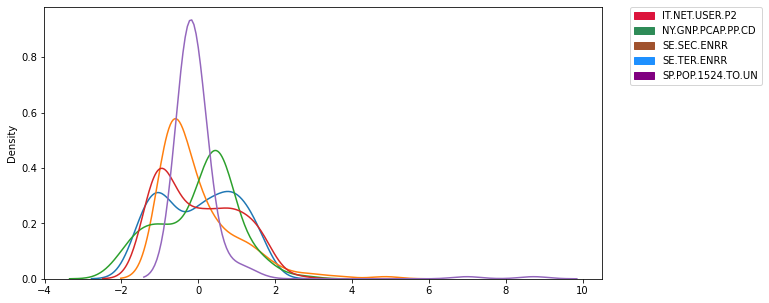

In [109]:
scaler_std = StandardScaler()
scaled_df_std= scaler_std.fit_transform(df_score[cols])
scaled_df_std = pd.DataFrame(scaled_df_std, columns=cols)
outils.plot_graph(scaled_df_std)

**PowerTransformer**

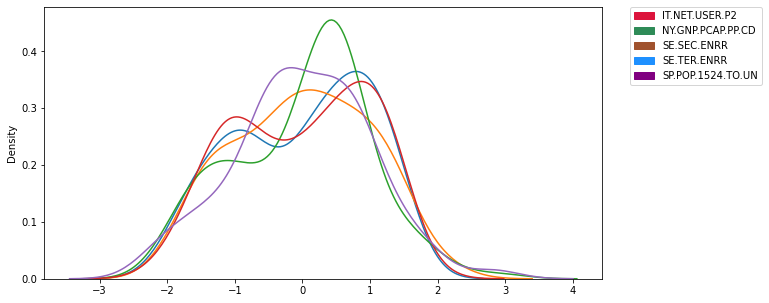

In [110]:
# Une transformation de Box Cox est une transformation d'une variable dépendante non normale en
# une forme normale.

scaler_pow = PowerTransformer(method = 'box-cox')
df_score_scaled= scaler_pow.fit_transform(df_score[cols])
df_score_scaled = pd.DataFrame(df_score_scaled, columns=cols)
outils.plot_graph(df_score_scaled)

Les statistiques descriptives des indicateurs ont montré la présence de courbes asymétriques (étalées à droite ou à gauche), les courbes de l'indicateur démographique et économique ont des observations plus concentrées et une variance élevée, avec des outliers. 

**La mise à l'échelle sera effectuée avec PowerTransformer()**.

<span style='background:PowderBlue'>**Pondération/Score d'attractivité**</span>

**Pondération**
                             
| Nature | Nom indicateur | Pondération |
| --- | --- | --- |
| démographique | SP.POP.1524.TO.UN | 4 |
| économique | NY.GNP.PCAP.PP.CD | 1 |
| éducatif | SE.SEC.ENRR | 2 |
| éducatif | SE.TER.ENRR | 3 |
| numérique | IT.NET.USER.P2 | 4 |


**Score d'attractivité**

In [111]:
# Calcul du score pour chaque pays en fonction des pondérations de chaque indicateur
#  num, eco, ed_sec, ed_ter et pop
df_score_scaled['Country Name'] = df_score.index
df_score_scaled['Score']=[(row[0] *4 + row[1] *1 + row[2] *2 + row[3] *3 + row[4]*4) for row in zip(df_score_scaled['IT.NET.USER.P2'], df_score_scaled['NY.GNP.PCAP.PP.CD'], df_score_scaled['SE.SEC.ENRR'], df_score_scaled['SE.TER.ENRR'], df_score_scaled['SP.POP.1524.TO.UN'])]
df_score_scaled.sort_values(by='Score',ascending=False).head(10)

,IT.NET.USER.P2,NY.GNP.PCAP.PP.CD,SE.SEC.ENRR,SE.TER.ENRR,SP.POP.1524.TO.UN,Country Name,Score
135,0.90469,1.46207,0.43800,1.34503,1.87674,United States,17.49887
6,1.18417,1.22293,1.85980,1.43348,0.29829,Australia,15.17283
134,1.38512,1.12602,1.50695,0.69000,0.85279,United Kingdom,15.16156
66,1.35997,1.15013,0.58328,0.85893,1.11284,Japan,14.78471
69,1.32219,0.95737,0.48369,1.48849,0.74974,"Korea, Rep.",14.67791
12,1.19764,1.22572,2.93822,1.12251,-0.17994,Belgium,14.54049
117,1.02157,0.96391,1.57898,1.42116,0.51646,Spain,14.53744
95,1.37776,1.31094,1.78385,1.19607,0.08806,Netherlands,14.33014
48,1.26665,1.29674,0.61535,0.97280,0.91926,Germany,14.18948
109,0.87198,0.58623,0.67885,1.23547,1.22098,Russian Federation,14.02221


**Score d'attractivité par région**

In [112]:
# Ajout de la région et du groupe de revenus
region_income = pd.DataFrame({'Country_Name' : df_pays['Country Name'], 
                                 'Region' : df_pays['Region'], 
                                 'Income Group' : df_pays['Income Group']})
df_score_scaled_region = pd.merge(df_score_scaled, region_income, left_on='Country Name', right_on='Country_Name', how='inner')
df_score_scaled_region.drop(columns=['Country_Name'],inplace=True)
df_score_scaled_region.drop_duplicates(inplace=True)
df_score_scaled_region.sort_values(by='Score',ascending=False).head(10);

# Constitution du dataframe de visualisation du regroupement par pays
df_score_region = df_score_scaled_region.groupby('Region').mean()
df_score_region=df_score_region.rename(columns={'IT.NET.USER.P2':'num',
                                                'NY.GNP.PCAP.PP.CD':'eco',
                                                'SE.SEC.ENRR':'edu_sec',
                                                'SE.TER.ENRR':'edu_ter',
                                                 'SP.POP.1524.TO.UN':'pop'})
df_score_region=df_score_region.sort_values(by='Score',ascending=False)

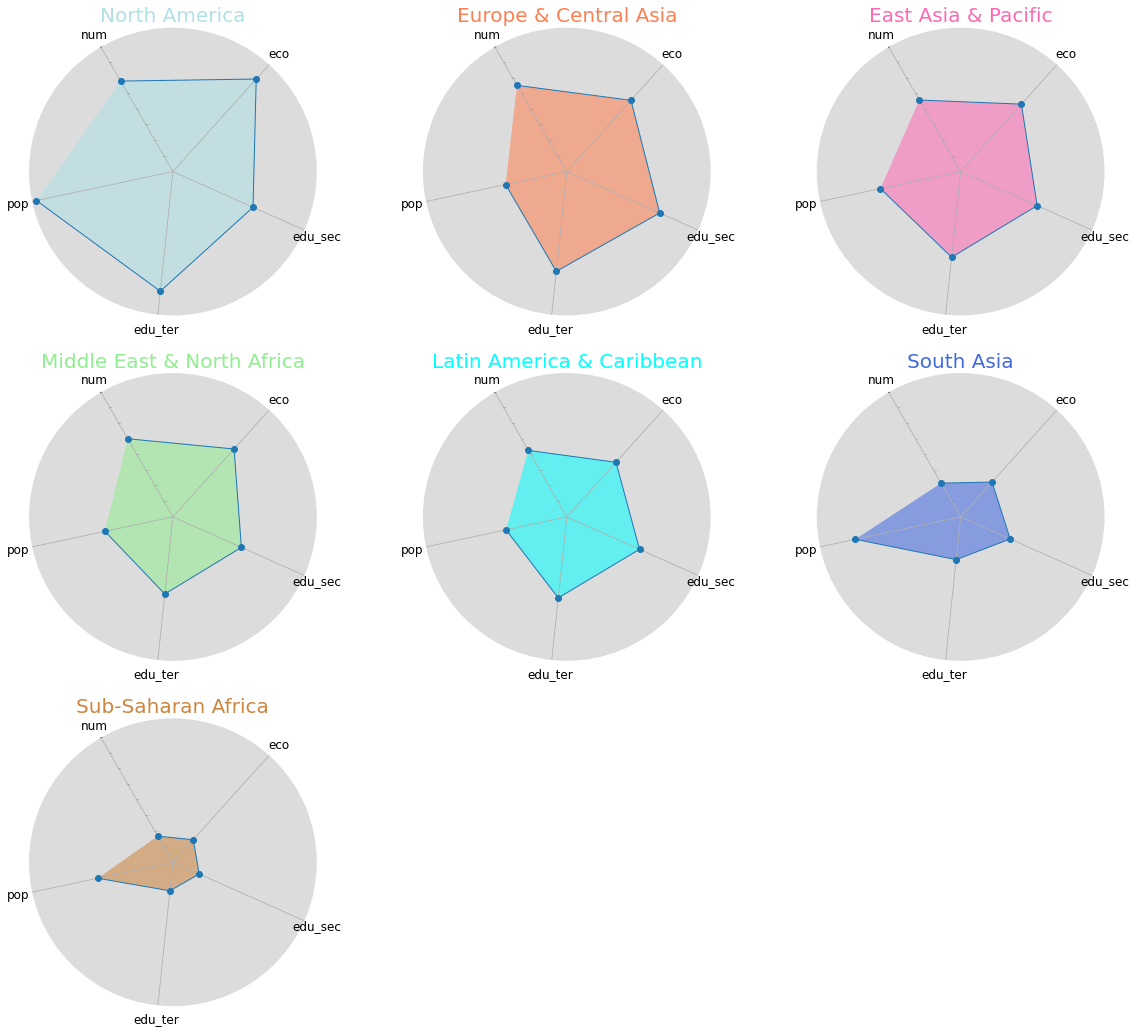

In [113]:
df_plot = df_score_region[['num','eco','edu_sec','edu_ter','pop']]
plt.rc('axes', facecolor = 'Gainsboro')

# number of variable
categories=list(df_plot.columns)

N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]

 
fig = plt.figure(1, figsize=(20,18))
    
colors = ['PowderBlue', 'Coral', 'HotPink', 'LightGreen', 'Cyan', 'RoyalBlue','Peru']

for i, region in enumerate(df_plot.index) : 
    
    ax = fig.add_subplot(3,3,i+1, polar=True)

    ax.set_theta_offset(2*pi/3)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles, categories, size=8)
    plt.yticks(color="grey", size=2)
    values=df_plot.iloc[i].values
    ax.plot(angles, values, 'o-', linewidth=1, linestyle='solid')
    ax.fill(angles, values, colors[i], alpha=0.55)
    ax.set_xticks(angles)
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_title(region, size=20, color=colors[i])
    ax.grid(True)
    plt.grid(True)
    plt.ylim(-2,2)

plt.show()

Plus l'aire dans le graphique est grande, plus la région a du potentiel.

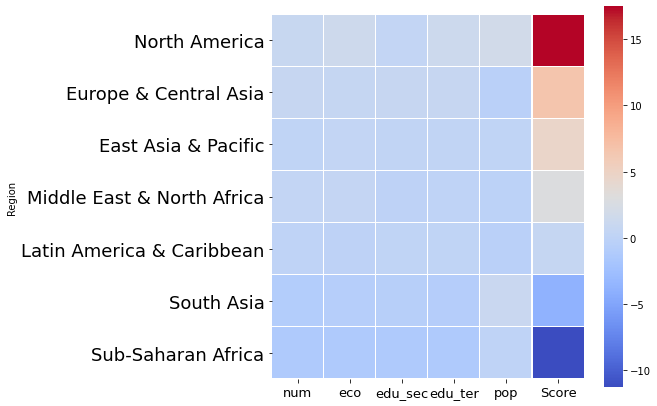

In [114]:
fig = plt.figure(1, figsize=(7, 7))
res = sns.heatmap(df_score_region, square=True, linewidths=0.1, cmap='coolwarm')
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 13)
plt.show()

3 régions se distinguent :

- 'North America', 
- 'Europe & Central Asia'
- et East Asia & Pacific'.

**Score d'attractivité par groupe de revenus**

In [115]:
df_score_income = df_score_scaled_region.groupby('Income Group').mean()
df_score_income=df_score_income.rename(columns={'IT.NET.USER.P2':'num',
                                                'NY.GNP.PCAP.PP.CD':'eco',
                                                'SE.SEC.ENRR':'edu_sec',
                                                'SE.TER.ENRR':'edu_ter',
                                                 'SP.POP.1524.TO.UN':'pop'})

df_score_income=df_score_income.sort_values(by='Score', ascending=False)

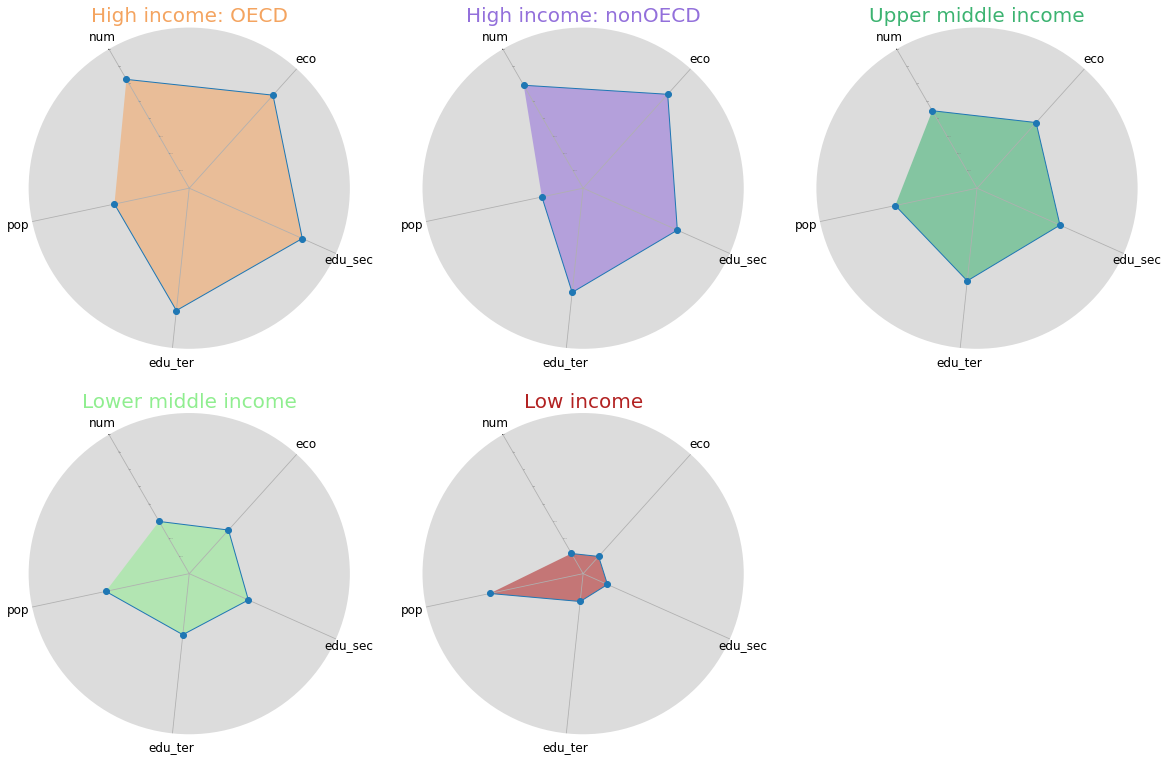

In [116]:
df_plot = df_score_income[['num','eco','edu_sec','edu_ter','pop']]

plt.rc('axes', facecolor = 'Gainsboro')

# number of variable
categories=list(df_plot.columns)
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]

 
fig = plt.figure(1, figsize=(20,13))
    
colors = ['SandyBrown', 'MediumPurple', 'MediumSeaGreen', 'LightGreen', 'FireBrick']

for i, region in enumerate(df_plot.index) : 
    
    ax = fig.add_subplot(2,3,i+1, polar=True)

    ax.set_theta_offset(2*pi/3)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles, categories, size=16)
    plt.yticks(color="grey", size=2)
    values=df_plot.iloc[i].values
    ax.plot(angles, values, 'o-', linewidth=1, linestyle='solid')
    ax.fill(angles, values, colors[i], alpha=0.55)
    ax.set_xticks(angles)
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_title(region, size=20, color=colors[i])
    ax.grid(True)
    plt.grid(True)
    plt.ylim(-2,2)

plt.show()

Plus l'aire dans le graphique est grande, plus le groupe de revenu a du potentiel.

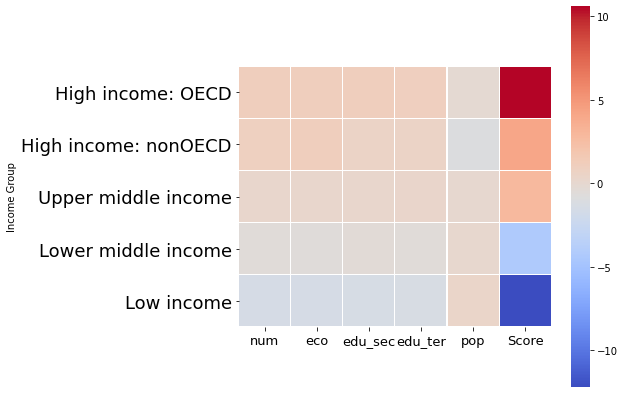

In [117]:
fig = plt.figure(1, figsize=(7, 7))
ax = sns.heatmap(df_score_income, square=True, linewidths=0.1, cmap='coolwarm')
ax.tick_params(axis='x',labelsize=13)
ax.tick_params(axis='y',labelsize=18)
plt.show()

Les groupes de revenus les plus attractifs sont :
- High income OECD et non OECD.
- Upper middle income

<span style='background:PowderBlue'>**Score d'attractivité représenté sur une carte du monde**</span>

In [118]:
#Importation du dataset des pays du monde de geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) 

# Dataset geopandas : code ISO-3166 alpha 3 et Nom court
df1=world.sort_values(by = ['iso_a3'])
df1=df1.loc[:,['iso_a3','name']]
df1=df1.rename(columns={'iso_a3':'ISO'})
df1=df1.set_index('ISO')

#  Dataset EdStatsCountry.csv : code ISO-3166 alpha 3 et Nom court
df2=country.sort_values(by = ['Country Code'])
df2=df2.loc[:,['Country Code','Short Name']]
df2=df2.rename(columns={'Country Code':'ISO'})
df2=df2.set_index('ISO')

# Fusion des 2 dataframes
df_comp_nom_pays= pd.merge(df1, df2, on='ISO', how='left')
df_comp_nom_pays.reset_index(inplace=True)

# Recherche des noms de pays différents entre geopandas et notre jeu de données
rows = df_comp_nom_pays[df_comp_nom_pays['name'] != df_comp_nom_pays['Short Name']]
rows.drop([0,1,2,3,4], inplace=True)
df_comp=rows[rows['Short Name'].notnull()].sort_values(by='ISO')
noms_a_changer=df_comp['Short Name'].tolist()
codes_iso=df_comp['ISO'].tolist()

# Récupération des index geopandas des noms de pays à changer
index_geo=world[world['iso_a3'].isin(codes_iso)].index
# Récupération des codes ISO 3 de geopandas
codes_isoa3=world.loc[index_geo,'iso_a3'].tolist()
# Parcours les codes ISO 3 pour avoir une liste de noms de pays dans l'ordre des index geopandas
noms_a_changer=[]
[noms_a_changer.append(df_comp[df_comp['ISO'] == iso]['Short Name'].tolist()[0]) for iso in codes_isoa3]
# Changement du libellé des noms courts des pays de geopandas par ceux de notre jeux de données
world.loc[world.index[index_geo.tolist()],'name']=noms_a_changer

# Pays écartés représentés en blanc sur la carte
df_pays_ecartes=pd.DataFrame({'Country Name': df_pays_retires.index, 'Score': np.zeros((70,), dtype=int)})
df_pays_ecartes.drop(index = [20,33,36,37,38,39,40,41,42,43,44,45,46,48,49,50,52,53,55,56,57,59,61,63,65,67,68,69], inplace = True) 
df_pays_ecartes.loc[3, 'Country Name'] = 'Venezuela'
df_pays_ecartes.loc[34, 'Country Name'] = 'The Bahamas'
df_pays_ecartes.loc[6, 'Country Name'] = 'Dem. People\'s Rep. Korea'
df_pays_ecartes.loc[47, 'Country Name'] = 'Dominican Republic'
df_pays_ecartes.shape

(42, 2)

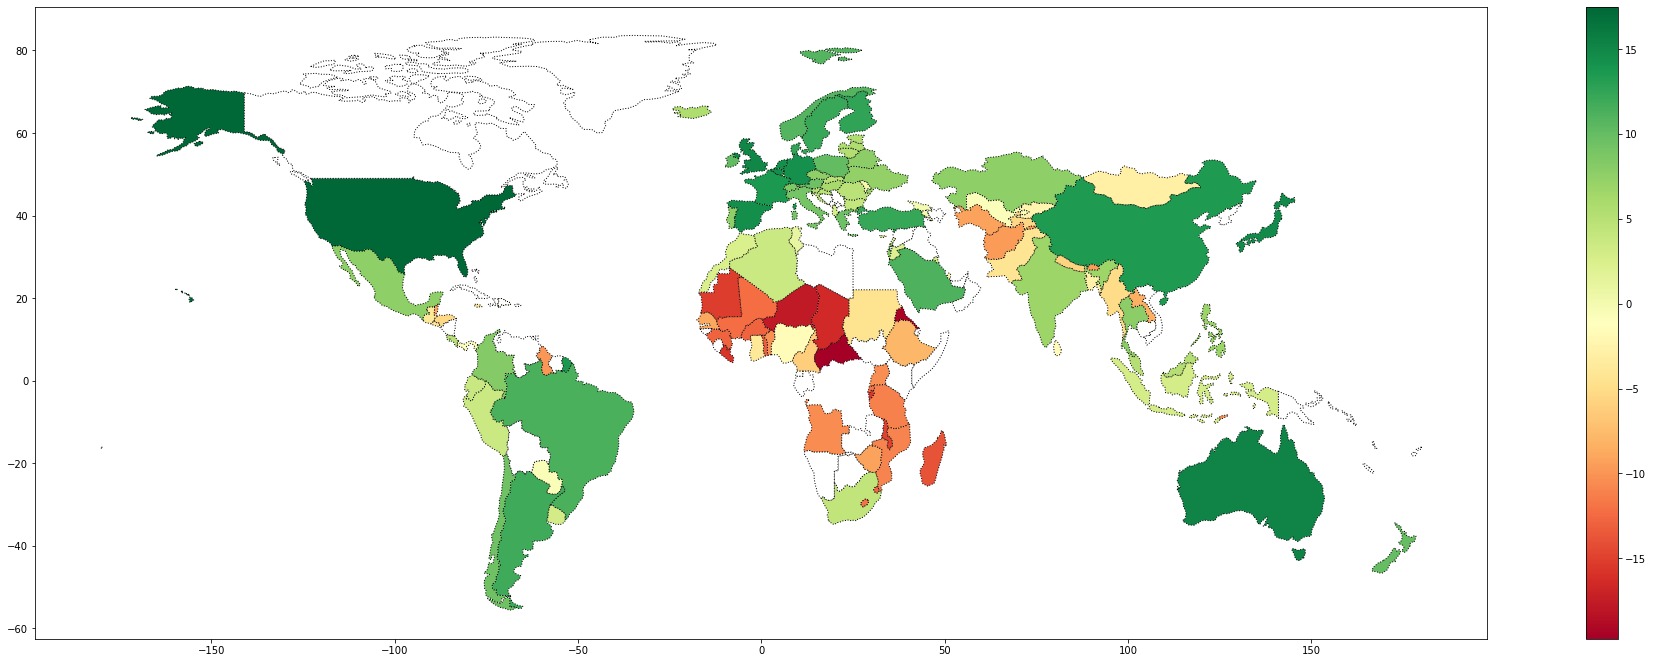

In [119]:
df_score_geo = world.merge(df_score_scaled, left_on = 'name', right_on = 'Country Name')[['geometry','Country Name','Score']]
df_pays_ecartes_geo = world.merge(df_pays_ecartes, left_on = 'name', right_on = 'Country Name')[['geometry','Country Name','Score']]

fig, ax = plt.subplots()
fig.set_size_inches(30,18)

ax.set_facecolor('xkcd:white')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
df_score_geo.plot(column=df_score_geo['Score'], legend = True, ax=ax, cax=cax, cmap='RdYlGn',linestyle=":",edgecolor='black' )
df_pays_ecartes_geo.plot(column=df_pays_ecartes['Score'], legend = True, ax=ax, cax=cax, color='white',linestyle=":",edgecolor='black' )

plt.show()

**Bilan : Top 10 des pays attractifs**

In [120]:
df_top10_prov = df_score_scaled[['Country Name','Score']].sort_values(by='Score',ascending=False).head(10)
df_top10_prov['Place Provisoire']=np.arange(1, 11, 1)
df_top10_prov.rename(columns={'Country Name': 'Pays'}, inplace=True)
df_top10_prov.set_index('Place Provisoire')


,Pays,Score
Place Provisoire,,
1,United States,17.49887
2,Australia,15.17283
3,United Kingdom,15.16156
4,Japan,14.78471
5,"Korea, Rep.",14.67791
6,Belgium,14.54049
7,Spain,14.53744
8,Netherlands,14.33014
9,Germany,14.18948


In [121]:
df_top10_region=df_pays[df_pays['Country Code'].isin(['AUS', 'USA','GBR','JAP','KOR','BEL','ESP','NDL','DEU','RUS'])][['Country Name','Region','Income Group']]
df_top10_region.drop_duplicates(inplace=True)
df_top10_region.set_index('Country Name', inplace=True)
df_top10_region.sort_values(by='Region', inplace=True)
df_top10_region

,Region,Income Group
Country Name,,
Australia,East Asia & Pacific,High income: OECD
"Korea, Rep.",East Asia & Pacific,High income: OECD
Belgium,Europe & Central Asia,High income: OECD
Germany,Europe & Central Asia,High income: OECD
Russian Federation,Europe & Central Asia,High income: nonOECD
Spain,Europe & Central Asia,High income: OECD
United Kingdom,Europe & Central Asia,High income: OECD
United States,North America,High income: OECD


Les 10 pays les plus attractifs font bien parties des 3 régions :
- East Asia & Pacific,
- Europe & Central Asia,
- North America	

et des 2 groupes de revenus :
- High income: OECD,
- High income: nonOECD

notés lors de l'analyse des indicateurs retenus.

## <span style='background:Thistle'>8. Prédictions</span>

<span style='background:PowderBlue'>**Utilisation des prédictions de EdStatsData.csv**</span>

In [122]:
# Données de prédictions existent pour nos pays Top10 pour les années 2020-2040?
df_score_pred=data.copy()
df_score_pred=df_score_pred[['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code','2020','2025','2030','2035','2040']]
# Filtre par codes indicateurs retenus
cols = ['IT.NET.USER.P2','NY.GNP.PCAP.PP.CD','SE.SEC.ENRR','SE.TER.ENRR','SP.POP.1524.TO.UN']
mask_indic=df_score_pred['Indicator Code'].isin(cols)
# Filtre par les pays Top 10
pays_top10=df_top10_prov['Pays'].tolist()
mask_top10=df_score_pred['Country Name'].isin(pays_top10)
# Dataframe avec les données de prédictions
df_score_pred=df_score_pred[mask_indic][mask_top10]

In [123]:
df_score_pred[['2020','2025','2030','2035','2040']].isna().sum().sum() == 0

False

 **Conclusion** : aucune données pour nos pays dans le top 10 sur les années de prédictions 2020-2040

<span style='background:PowderBlue'>**Méthode de Holt's**</span>

Economie, population : série temporelle avec tendance mais sans saisonnalité ==> méthode Holt's de la librairie statsmodels

In [124]:
# Données de prédictions existent pour nos pays Top10 pour les années 2020-2040?
df_score_holt=data.copy()
df_score_holt=df_score_holt[['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code','2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014','2015','2016']]
#  Variables quantitatives
df_numeric = df_score_holt[['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014','2015','2016']]
# Variables qualitatives
df_categ = df_score_holt.loc[:, ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']]
df_numeric.interpolate(method='linear', axis=1, inplace=True)
df_score_holt = pd.concat([df_categ, df_numeric], axis=1)
# Filtre par codes indicateurs retenus
cols = ['IT.NET.USER.P2','NY.GNP.PCAP.PP.CD','SE.SEC.ENRR','SE.TER.ENRR','SP.POP.1524.TO.UN']
mask_indic=df_score_holt['Indicator Code'].isin(cols)
# Filtre par les pays Top 10
pays_top10=df_top10_prov['Pays'].tolist()
mask_top10=df_score_holt['Country Name'].isin(pays_top10)
# Dataframe avec les données de prédictions
df_score_holt=df_score_holt[mask_indic][mask_top10]
df_score_holt;

In [137]:
cols_holt=['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014','2015','2016']
x_index=pd.date_range(start='2000', end='2017', freq='A')

# ----------------------------------------------------------------------------------------------------------------------
# Indicateurs économique - NY.GNP.PCAP.PP.CD
# -----------------------------------------------------------------------------------------------------------------------

# Préparation du jeu de données
df_holt_eco=df_score_holt[df_score_holt['Indicator Code']=='NY.GNP.PCAP.PP.CD'][cols_holt]
# Australie
ind_eco_aus=df_holt_eco[df_score_holt['Country Name']=='Australia'].values.tolist()[0]
y_eco_aus = pd.Series(ind_eco_aus, x_index)
# Belgique
ind_eco_bel=df_holt_eco[df_score_holt['Country Name']=='Belgium'].values.tolist()[0]
y_eco_bel = pd.Series(ind_eco_bel, x_index)
# Allemagne
ind_eco_deu=df_holt_eco[df_score_holt['Country Name']=='Germany'].values.tolist()[0]
y_eco_deu = pd.Series(ind_eco_deu, x_index)
# Japon
ind_eco_jpn=df_holt_eco[df_score_holt['Country Name']=='Japan'].values.tolist()[0]
y_eco_jpn = pd.Series(ind_eco_jpn, x_index)
# Corée du Sud
ind_eco_kor=df_holt_eco[df_score_holt['Country Name']=='Korea, Rep.'].values.tolist()[0]
y_eco_kor = pd.Series(ind_eco_kor, x_index)
# Pays-bas
ind_eco_nld=df_holt_eco[df_score_holt['Country Name']=='Netherlands'].values.tolist()[0]
y_eco_nld = pd.Series(ind_eco_nld, x_index)
# Russie
ind_eco_rus=df_holt_eco[df_score_holt['Country Name']=='Russian Federation'].values.tolist()[0]
y_eco_rus = pd.Series(ind_eco_rus, x_index)
# Espagne
ind_eco_esp=df_holt_eco[df_score_holt['Country Name']=='Spain'].values.tolist()[0]
y_eco_esp = pd.Series(ind_eco_esp, x_index)
# Royaume-Unis 
ind_eco_gbr=df_holt_eco[df_score_holt['Country Name']=='United Kingdom'].values.tolist()[0]
y_eco_gbr = pd.Series(ind_eco_gbr, x_index)
# Etats-Unis
ind_eco_usa=df_holt_eco[df_score_holt['Country Name']=='United States'].values.tolist()[0]
y_eco_usa = pd.Series(ind_eco_usa, x_index)

# Entrainement du modèle
fit1 = Holt(y_eco_aus, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast1 = fit1.forecast(3).rename('Australia')
fit2 = Holt(y_eco_bel, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast2 = fit2.forecast(3).rename('Belgique')
fit3 = Holt(y_eco_deu, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast3 = fit3.forecast(3).rename('Allemagne')
fit4 = Holt(y_eco_jpn, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast4 = fit4.forecast(3).rename('Japon')
fit5 = Holt(y_eco_kor, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast5 = fit5.forecast(3).rename('Corée Sud')
fit6 = Holt(y_eco_nld, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast6 = fit6.forecast(3).rename('Pays-Bas')
fit7 = Holt(y_eco_rus, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast7 = fit7.forecast(3).rename('Russie')
fit8 = Holt(y_eco_esp, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast8 = fit8.forecast(3).rename('Espagne')
fit9 = Holt(y_eco_gbr, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast9 = fit9.forecast(3).rename('Royaume-Unis')
fit10 = Holt(y_eco_usa, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast10 = fit10.forecast(3).rename('Etats-Unis')

# Sauvegarde de la prédiction éco pour scoring
df_prediction = pd.DataFrame(index=np.arange(0, 50), columns=('Country Name','Indicator Code','2017','2018','2019') )
df_prediction.loc[0] = ['Australia', 'NY.GNP.PCAP.PP.CD', fcast1[0], fcast1[1], fcast1[2]]
df_prediction.loc[1] = ['Belgium', 'NY.GNP.PCAP.PP.CD', fcast2[0], fcast2[1], fcast2[2]]
df_prediction.loc[2] = ['Germany', 'NY.GNP.PCAP.PP.CD', fcast3[0], fcast3[1], fcast3[2]]
df_prediction.loc[3] = ['Japan', 'NY.GNP.PCAP.PP.CD', fcast4[0], fcast4[1], fcast4[2]]
df_prediction.loc[4] = ['Korea, Rep.', 'NY.GNP.PCAP.PP.CD', fcast5[0], fcast5[1], fcast5[2]]
df_prediction.loc[5] = ['Netherlands', 'NY.GNP.PCAP.PP.CD', fcast6[0], fcast6[1], fcast6[2]]
df_prediction.loc[6] = ['Russian Federation', 'NY.GNP.PCAP.PP.CD', fcast7[0], fcast7[1], fcast7[2]]
df_prediction.loc[7] = ['Spain', 'NY.GNP.PCAP.PP.CD', fcast8[0], fcast8[1], fcast8[2]]
df_prediction.loc[8] = ['United Kingdom', 'NY.GNP.PCAP.PP.CD', fcast9[0], fcast9[1], fcast9[2]]
df_prediction.loc[9] = ['United States', 'NY.GNP.PCAP.PP.CD', fcast10[0], fcast10[1], fcast10[2]]

# -----------------------------------------------------------------------------------------------------------------------
# Indicateurs démographique - SP.POP.1524.TO.UN
# -----------------------------------------------------------------------------------------------------------------------

# Préparation du jeu de données
df_holt_pop=df_score_holt[df_score_holt['Indicator Code']=='SP.POP.1524.TO.UN'][cols_holt]
# Australie
ind_pop_aus=df_holt_pop[df_score_holt['Country Name']=='Australia'].values.tolist()[0]
y_pop_aus = pd.Series(ind_pop_aus, x_index)
# Belgique
ind_pop_bel=df_holt_pop[df_score_holt['Country Name']=='Belgium'].values.tolist()[0]
y_pop_bel = pd.Series(ind_pop_bel, x_index)
# Allemagne
ind_pop_deu=df_holt_pop[df_score_holt['Country Name']=='Germany'].values.tolist()[0]
y_pop_deu = pd.Series(ind_pop_deu, x_index)
# Japon
ind_pop_jpn=df_holt_pop[df_score_holt['Country Name']=='Japan'].values.tolist()[0]
y_pop_jpn = pd.Series(ind_pop_jpn, x_index)
# Corée du Sud
ind_pop_kor=df_holt_pop[df_score_holt['Country Name']=='Korea, Rep.'].values.tolist()[0]
y_pop_kor = pd.Series(ind_pop_kor, x_index)
# Pays-bas
ind_pop_nld=df_holt_pop[df_score_holt['Country Name']=='Netherlands'].values.tolist()[0]
y_pop_nld = pd.Series(ind_pop_nld, x_index)
# Russie
ind_pop_rus=df_holt_pop[df_score_holt['Country Name']=='Russian Federation'].values.tolist()[0]
y_pop_rus = pd.Series(ind_pop_rus, x_index)
# Espagne
ind_pop_esp=df_holt_pop[df_score_holt['Country Name']=='Spain'].values.tolist()[0]
y_pop_esp = pd.Series(ind_pop_esp, x_index)
# Royaume-Unis 
ind_pop_gbr=df_holt_pop[df_score_holt['Country Name']=='United Kingdom'].values.tolist()[0]
y_pop_gbr = pd.Series(ind_pop_gbr, x_index)
# Etats-Unis
ind_pop_usa=df_holt_pop[df_score_holt['Country Name']=='United States'].values.tolist()[0]
y_pop_usa = pd.Series(ind_pop_usa, x_index)

# Entrainement du modèle
fit11 = Holt(y_pop_aus, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast11 = fit11.forecast(3).rename('Australia')
fit12 = Holt(y_pop_bel, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast12 = fit12.forecast(3).rename('Belgique')
fit13 = Holt(y_pop_deu, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast13 = fit13.forecast(3).rename('Allemagne')
fit14 = Holt(y_pop_jpn, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast14 = fit14.forecast(3).rename('Japon')
fit15 = Holt(y_pop_kor, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast15 = fit15.forecast(3).rename('Corée Sud')
fit16 = Holt(y_pop_nld, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast16 = fit16.forecast(3).rename('Pays-Bas')
fit17 = Holt(y_pop_rus, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast17 = fit17.forecast(3).rename('Russie')
fit18 = Holt(y_pop_esp, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast18 = fit18.forecast(3).rename('Espagne')
fit19 = Holt(y_pop_gbr, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast19 = fit19.forecast(3).rename('Royaume-Unis')
fit20 = Holt(y_pop_usa, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast20 = fit20.forecast(3).rename('Etats-Unis')

# Sauvegarde de la prédiction pop pour scoring
df_prediction.loc[10] = ['Australia', 'SP.POP.1524.TO.UN', fcast11[0], fcast11[1], fcast11[2]]
df_prediction.loc[11] = ['Belgium', 'SP.POP.1524.TO.UN', fcast12[0], fcast12[1], fcast12[2]]
df_prediction.loc[12] = ['Germany', 'SP.POP.1524.TO.UN', fcast13[0], fcast13[1], fcast13[2]]
df_prediction.loc[13] = ['Japan', 'SP.POP.1524.TO.UN', fcast14[0], fcast14[1], fcast14[2]]
df_prediction.loc[14] = ['Korea, Rep.', 'SP.POP.1524.TO.UN', fcast15[0], fcast15[1], fcast15[2]]
df_prediction.loc[15] = ['Netherlands', 'SP.POP.1524.TO.UN', fcast16[0], fcast16[1], fcast16[2]]
df_prediction.loc[16] = ['Russian Federation', 'SP.POP.1524.TO.UN', fcast17[0], fcast17[1], fcast17[2]]
df_prediction.loc[17] = ['Spain', 'SP.POP.1524.TO.UN', fcast18[0], fcast18[1], fcast18[2]]
df_prediction.loc[18] = ['United Kingdom', 'SP.POP.1524.TO.UN', fcast19[0], fcast19[1], fcast19[2]]
df_prediction.loc[19] = ['United States', 'SP.POP.1524.TO.UN', fcast20[0], fcast20[1], fcast20[2]]

# -----------------------------------------------------------------------------------------------------------------------
# Indicateurs éducatif lycée - SE.SEC.ENRR
# -----------------------------------------------------------------------------------------------------------------------

# Préparation du jeu de données
df_holt_edu_sec=df_score_holt[df_score_holt['Indicator Code']=='SE.SEC.ENRR'][cols_holt]
# Australie
ind_edu_sec_aus=df_holt_edu_sec[df_score_holt['Country Name']=='Australia'].values.tolist()[0]
y_edu_sec_aus = pd.Series(ind_edu_sec_aus, x_index)
# Belgique
ind_edu_sec_bel=df_holt_edu_sec[df_score_holt['Country Name']=='Belgium'].values.tolist()[0]
y_edu_sec_bel = pd.Series(ind_edu_sec_bel, x_index)
# Allemagne
ind_edu_sec_deu=df_holt_edu_sec[df_score_holt['Country Name']=='Germany'].values.tolist()[0]
y_edu_sec_deu = pd.Series(ind_edu_sec_deu, x_index)
# Japon
ind_edu_sec_jpn=df_holt_edu_sec[df_score_holt['Country Name']=='Japan'].values.tolist()[0]
y_edu_sec_jpn = pd.Series(ind_edu_sec_jpn, x_index)
# Corée du Sud
ind_edu_sec_kor=df_holt_edu_sec[df_score_holt['Country Name']=='Korea, Rep.'].values.tolist()[0]
y_edu_sec_kor = pd.Series(ind_edu_sec_kor, x_index)
# Pays-bas
ind_edu_sec_nld=df_holt_edu_sec[df_score_holt['Country Name']=='Netherlands'].values.tolist()[0]
y_edu_sec_nld = pd.Series(ind_edu_sec_nld, x_index)
# Russie
ind_edu_sec_rus=df_holt_edu_sec[df_score_holt['Country Name']=='Russian Federation'].values.tolist()[0]
y_edu_sec_rus = pd.Series(ind_edu_sec_rus, x_index)
y_edu_sec_rus=y_edu_sec_rus.fillna(80)
# Espagne
ind_edu_sec_esp=df_holt_edu_sec[df_score_holt['Country Name']=='Spain'].values.tolist()[0]
y_edu_sec_esp = pd.Series(ind_edu_sec_esp, x_index)
# Royaume-Unis 
ind_edu_sec_gbr=df_holt_edu_sec[df_score_holt['Country Name']=='United Kingdom'].values.tolist()[0]
y_edu_sec_gbr = pd.Series(ind_edu_sec_gbr, x_index)
# Etats-Unis
ind_edu_sec_usa=df_holt_edu_sec[df_score_holt['Country Name']=='United States'].values.tolist()[0]
y_edu_sec_usa = pd.Series(ind_edu_sec_usa, x_index)

# Entrainement du modèle
fit21 = Holt(y_edu_sec_aus, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast21 = fit21.forecast(3).rename('Australia')
fit22 = Holt(y_edu_sec_bel, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast22 = fit22.forecast(3).rename('Belgique')
fit23 = Holt(y_edu_sec_deu, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast23 = fit23.forecast(3).rename('Allemagne')
fit24 = Holt(y_edu_sec_jpn, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast24 = fit24.forecast(3).rename('Japon')
fit25 = Holt(y_edu_sec_kor, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast25 = fit25.forecast(3).rename('Corée Sud')
fit26 = Holt(y_edu_sec_nld, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast26 = fit26.forecast(3).rename('Pays-Bas')
fit27 = Holt(y_edu_sec_rus, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast27 = fit27.forecast(3).rename('Russie')
fit28 = Holt(y_edu_sec_esp, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast28 = fit28.forecast(3).rename('Espagne')
fit29 = Holt(y_edu_sec_gbr, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast29 = fit29.forecast(3).rename('Royaume-Unis')
fit30 = Holt(y_edu_sec_usa, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast30 = fit30.forecast(3).rename('Etats-Unis')

# Sauvegarde de la prédiction édu_sec pour scoring
df_prediction.loc[20] = ['Australia', 'SE.SEC.ENRR', fcast21[0], fcast21[1], fcast21[2]]
df_prediction.loc[21] = ['Belgium', 'SE.SEC.ENRR', fcast22[0], fcast22[1], fcast22[2]]
df_prediction.loc[22] = ['Germany', 'SE.SEC.ENRR', fcast23[0], fcast23[1], fcast23[2]]
df_prediction.loc[23] = ['Japan', 'SE.SEC.ENRR', fcast24[0], fcast24[1], fcast24[2]]
df_prediction.loc[24] = ['Korea, Rep.', 'SE.SEC.ENRR', fcast25[0], fcast25[1], fcast25[2]]
df_prediction.loc[25] = ['Netherlands', 'SE.SEC.ENRR', fcast26[0], fcast26[1], fcast26[2]]
df_prediction.loc[26] = ['Russian Federation', 'SE.SEC.ENRR', fcast27[0], fcast27[1], fcast27[2]]
df_prediction.loc[27] = ['Spain', 'SE.SEC.ENRR', fcast28[0], fcast28[1], fcast28[2]]
df_prediction.loc[28] = ['United Kingdom', 'SE.SEC.ENRR', fcast29[0], fcast29[1], fcast29[2]]
df_prediction.loc[29] = ['United States', 'SE.SEC.ENRR', fcast30[0], fcast30[1], fcast30[2]]

# -----------------------------------------------------------------------------------------------------------------------
# Indicateurs éducatif enseignement supérieur - SE.TER.ENRR
# -----------------------------------------------------------------------------------------------------------------------

# Préparation du jeu de données
df_holt_edu_ter=df_score_holt[df_score_holt['Indicator Code']=='SE.TER.ENRR'][cols_holt]
# Australie
ind_edu_ter_aus=df_holt_edu_ter[df_score_holt['Country Name']=='Australia'].values.tolist()[0]
y_edu_ter_aus = pd.Series(ind_edu_ter_aus, x_index)
# Belgique
ind_edu_ter_bel=df_holt_edu_ter[df_score_holt['Country Name']=='Belgium'].values.tolist()[0]
y_edu_ter_bel = pd.Series(ind_edu_ter_bel, x_index)
# Allemagne
ind_edu_ter_deu=df_holt_edu_ter[df_score_holt['Country Name']=='Germany'].values.tolist()[0]
y_edu_ter_deu = pd.Series(ind_edu_ter_deu, x_index)
y_edu_ter_deu=y_edu_ter_deu.fillna(60)
# Japon
ind_edu_ter_jpn=df_holt_edu_ter[df_score_holt['Country Name']=='Japan'].values.tolist()[0]
y_edu_ter_jpn = pd.Series(ind_edu_ter_jpn, x_index)
# Corée du Sud
ind_edu_ter_kor=df_holt_edu_ter[df_score_holt['Country Name']=='Korea, Rep.'].values.tolist()[0]
y_edu_ter_kor = pd.Series(ind_edu_ter_kor, x_index)
# Pays-bas
ind_edu_ter_nld=df_holt_edu_ter[df_score_holt['Country Name']=='Netherlands'].values.tolist()[0]
y_edu_ter_nld = pd.Series(ind_edu_ter_nld, x_index)
# Russie
ind_edu_ter_rus=df_holt_edu_ter[df_score_holt['Country Name']=='Russian Federation'].values.tolist()[0]
y_edu_ter_rus = pd.Series(ind_edu_ter_rus, x_index)
# Espagne
ind_edu_ter_esp=df_holt_edu_ter[df_score_holt['Country Name']=='Spain'].values.tolist()[0]
y_edu_ter_esp = pd.Series(ind_edu_ter_esp, x_index)
# Royaume-Unis 
ind_edu_ter_gbr=df_holt_edu_ter[df_score_holt['Country Name']=='United Kingdom'].values.tolist()[0]
y_edu_ter_gbr = pd.Series(ind_edu_ter_gbr, x_index)
# Etats-Unis
ind_edu_ter_usa=df_holt_edu_ter[df_score_holt['Country Name']=='United States'].values.tolist()[0]
y_edu_ter_usa = pd.Series(ind_edu_ter_usa, x_index)

# Entrainement du modèle
fit31 = Holt(y_edu_ter_aus, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast31 = fit31.forecast(3).rename('Australia')
fit32 = Holt(y_edu_ter_bel, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast32 = fit32.forecast(3).rename('Belgique')
fit33 = Holt(y_edu_ter_deu, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast33 = fit33.forecast(3).rename('Allemagne')
fit34 = Holt(y_edu_ter_jpn, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast34 = fit34.forecast(3).rename('Japon')
fit35 = Holt(y_edu_ter_kor, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast35 = fit35.forecast(3).rename('Corée Sud')
fit36 = Holt(y_edu_ter_nld, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast36 = fit36.forecast(3).rename('Pays-Bas')
fit37 = Holt(y_edu_ter_rus, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast37 = fit37.forecast(3).rename('Russie')
fit38 = Holt(y_edu_ter_esp, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast38 = fit38.forecast(3).rename('Espagne')
fit39 = Holt(y_edu_ter_gbr, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast39 = fit39.forecast(3).rename('Royaume-Unis')
fit40 = Holt(y_edu_ter_usa, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast40 = fit40.forecast(3).rename('Etats-Unis')

# Sauvegarde de la prédiction éduc_ter pour scoring
df_prediction.loc[30] = ['Australia', 'SE.TER.ENRR', fcast31[0], fcast31[1], fcast31[2]]
df_prediction.loc[31] = ['Belgium', 'SE.TER.ENRR', fcast32[0], fcast32[1], fcast32[2]]
df_prediction.loc[32] = ['Germany', 'SE.TER.ENRR', fcast33[0], fcast33[1], fcast33[2]]
df_prediction.loc[33] = ['Japan', 'SE.TER.ENRR', fcast34[0], fcast34[1], fcast34[2]]
df_prediction.loc[34] = ['Korea, Rep.', 'SE.TER.ENRR', fcast35[0], fcast35[1], fcast35[2]]
df_prediction.loc[35] = ['Netherlands', 'SE.TER.ENRR', fcast36[0], fcast36[1], fcast36[2]]
df_prediction.loc[36] = ['Russian Federation', 'SE.TER.ENRR', fcast37[0], fcast37[1], fcast37[2]]
df_prediction.loc[37] = ['Spain', 'SE.TER.ENRR', fcast38[0], fcast38[1], fcast38[2]]
df_prediction.loc[38] = ['United Kingdom', 'SE.TER.ENRR', fcast39[0], fcast39[1], fcast39[2]]
df_prediction.loc[39] = ['United States', 'SE.TER.ENRR', fcast40[0], fcast40[1], fcast40[2]]

# -----------------------------------------------------------------------------------------------------------------------
# Indicateurs numérique - IT.NET.USER.P2
# -----------------------------------------------------------------------------------------------------------------------

# Préparation du jeu de données
df_holt_num=df_score_holt[df_score_holt['Indicator Code']=='IT.NET.USER.P2'][cols_holt]
# Australie
ind_num_aus=df_holt_num[df_score_holt['Country Name']=='Australia'].values.tolist()[0]
y_num_aus = pd.Series(ind_num_aus, x_index)
# Belgique
ind_num_bel=df_holt_num[df_score_holt['Country Name']=='Belgium'].values.tolist()[0]
y_num_bel = pd.Series(ind_num_bel, x_index)
# Allemagne
ind_num_deu=df_holt_num[df_score_holt['Country Name']=='Germany'].values.tolist()[0]
y_num_deu = pd.Series(ind_num_deu, x_index)
# Japon
ind_num_jpn=df_holt_num[df_score_holt['Country Name']=='Japan'].values.tolist()[0]
y_num_jpn = pd.Series(ind_num_jpn, x_index)
# Corée du Sud
ind_num_kor=df_holt_num[df_score_holt['Country Name']=='Korea, Rep.'].values.tolist()[0]
y_num_kor = pd.Series(ind_num_kor, x_index)
# Pays-bas
ind_num_nld=df_holt_num[df_score_holt['Country Name']=='Netherlands'].values.tolist()[0]
y_num_nld = pd.Series(ind_num_nld, x_index)
# Russie
ind_num_rus=df_holt_num[df_score_holt['Country Name']=='Russian Federation'].values.tolist()[0]
y_num_rus = pd.Series(ind_num_rus, x_index)
# Espagne
ind_num_esp=df_holt_num[df_score_holt['Country Name']=='Spain'].values.tolist()[0]
y_num_esp = pd.Series(ind_num_esp, x_index)
# Royaume-Unis 
ind_num_gbr=df_holt_num[df_score_holt['Country Name']=='United Kingdom'].values.tolist()[0]
y_num_gbr = pd.Series(ind_num_gbr, x_index)
# Etats-Unis
ind_num_usa=df_holt_num[df_score_holt['Country Name']=='United States'].values.tolist()[0]
y_num_usa = pd.Series(ind_num_usa, x_index)

# Entrainement du modèle
fit41 = Holt(y_num_aus, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast41 = fit41.forecast(3).rename('Australia')
fit42 = Holt(y_num_bel, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast42 = fit42.forecast(3).rename('Belgique')
fit43 = Holt(y_num_deu, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast43 = fit43.forecast(3).rename('Allemagne')
fit44 = Holt(y_num_jpn, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast44 = fit44.forecast(3).rename('Japon')
fit45 = Holt(y_num_kor, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast45 = fit45.forecast(3).rename('Corée Sud')
fit46 = Holt(y_num_nld, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast46 = fit46.forecast(3).rename('Pays-Bas')
fit47 = Holt(y_num_rus, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast47 = fit47.forecast(3).rename('Russie')
fit48 = Holt(y_num_esp, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast48 = fit48.forecast(3).rename('Espagne')
fit49 = Holt(y_num_gbr, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast49 = fit49.forecast(3).rename('Royaume-Unis')
fit50 = Holt(y_num_usa, exponential=True, initialization_method='estimated').fit(optimized=True)
fcast50 = fit50.forecast(3).rename('Etats-Unis')

# Sauvegarde de la prédiction num pour scoring
df_prediction.loc[40] = ['Australia', 'IT.NET.USER.P2', fcast41[0], fcast41[1], fcast41[2]]
df_prediction.loc[41] = ['Belgium', 'IT.NET.USER.P2', fcast42[0], fcast42[1], fcast42[2]]
df_prediction.loc[42] = ['Germany', 'IT.NET.USER.P2', fcast43[0], fcast43[1], fcast43[2]]
df_prediction.loc[43] = ['Japan', 'IT.NET.USER.P2', fcast44[0], fcast44[1], fcast44[2]]
df_prediction.loc[44] = ['Korea, Rep.', 'IT.NET.USER.P2', fcast45[0], fcast45[1], fcast45[2]]
df_prediction.loc[45] = ['Netherlands', 'IT.NET.USER.P2', fcast46[0], fcast46[1], fcast46[2]]
df_prediction.loc[46] = ['Russian Federation', 'IT.NET.USER.P2', fcast47[0], fcast47[1], fcast47[2]]
df_prediction.loc[47] = ['Spain', 'IT.NET.USER.P2', fcast48[0], fcast48[1], fcast48[2]]
df_prediction.loc[48] = ['United Kingdom', 'IT.NET.USER.P2', fcast49[0], fcast49[1], fcast49[2]]
df_prediction.loc[49] = ['United States', 'IT.NET.USER.P2', fcast50[0], fcast50[1], fcast50[2]]

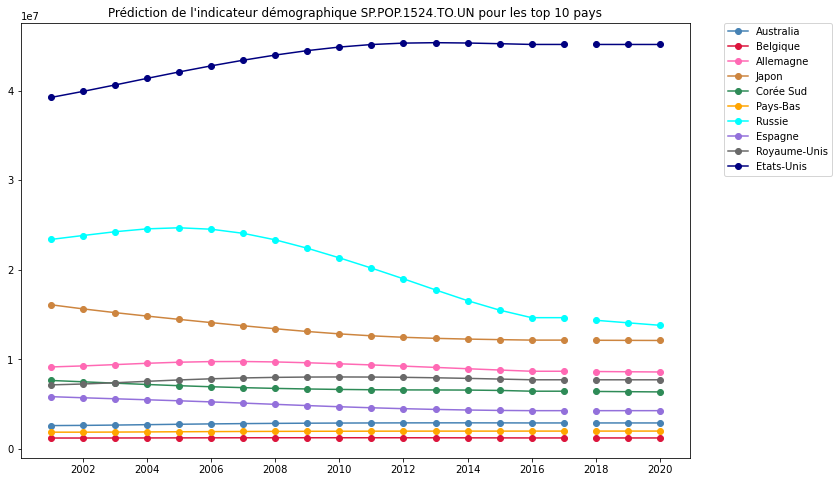

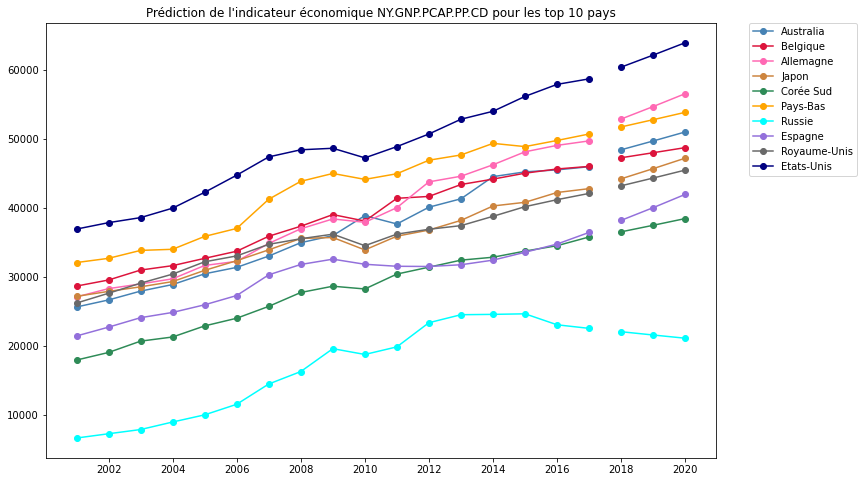

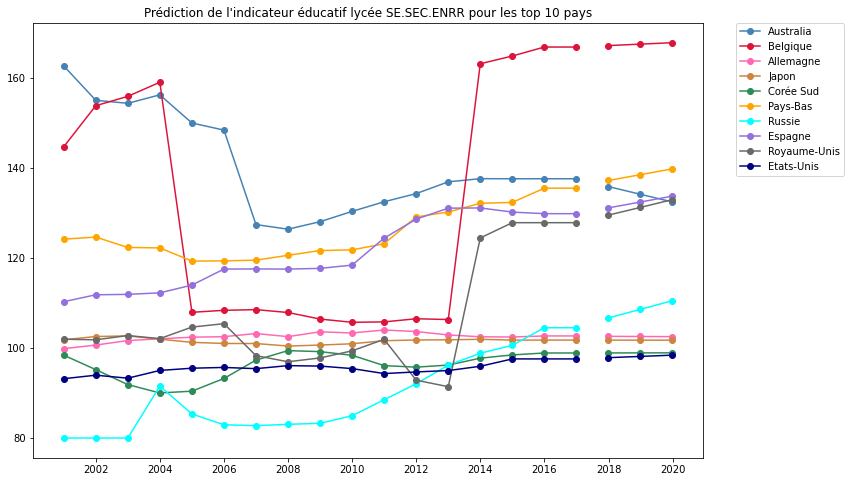

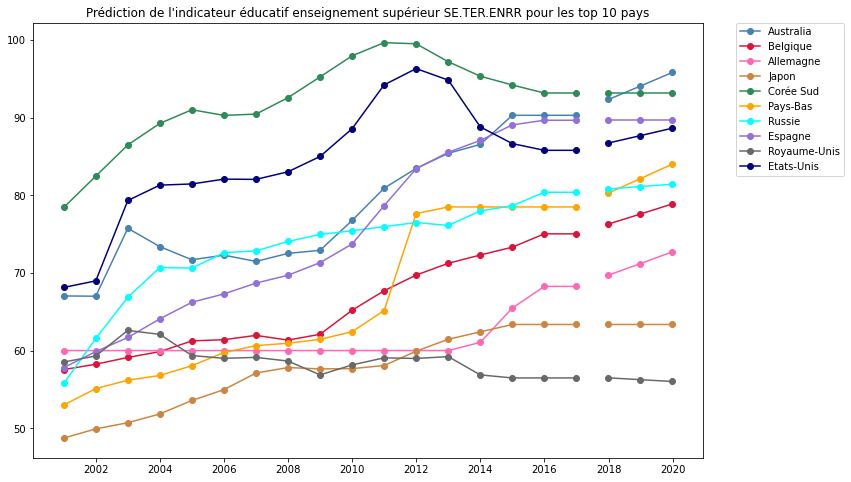

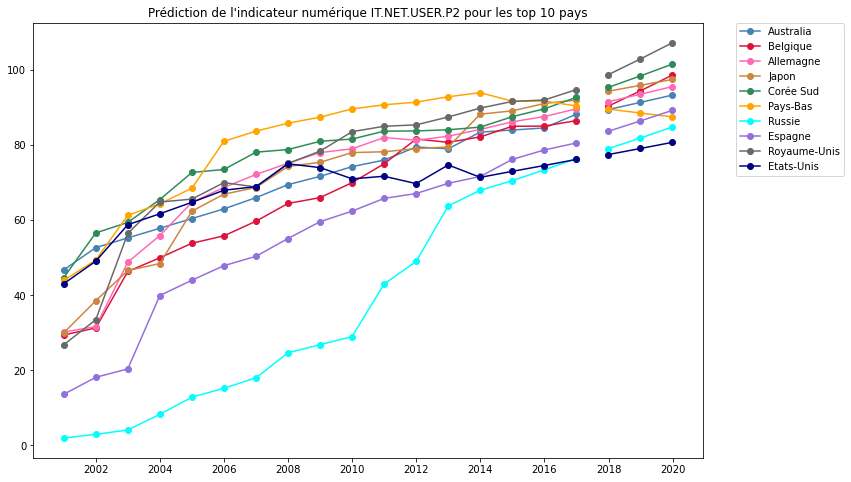

In [126]:
# Visualisation des prédictions
plt.figure(figsize=(12, 8))
ax = plt.axes()

plt.plot(y_pop_aus, marker='o', color='SteelBlue')
line11, = plt.plot(fcast11, marker='o', color='SteelBlue')
plt.plot(y_pop_bel, marker='o', color='Crimson')
line12, = plt.plot(fcast12, marker='o', color='Crimson')
plt.plot(y_pop_deu, marker='o', color='HotPink')
line13, = plt.plot(fcast13, marker='o', color='HotPink')
plt.plot(y_pop_jpn, marker='o', color='Peru')
line14, = plt.plot(fcast14, marker='o', color='Peru')
plt.plot(y_pop_kor, marker='o', color='SeaGreen')
line15, = plt.plot(fcast15, marker='o', color='SeaGreen')
plt.plot(y_pop_nld, marker='o', color='Orange')
line16, = plt.plot(fcast16, marker='o', color='Orange')
plt.plot(y_pop_rus, marker='o', color='Cyan')
line17, = plt.plot(fcast17, marker='o', color='Cyan')
plt.plot(y_pop_esp, marker='o', color='MediumPurple')
line18, = plt.plot(fcast18, marker='o', color='MediumPurple')
plt.plot(y_pop_gbr, marker='o', color='DimGray')
line19, = plt.plot(fcast19, marker='o', color='DimGray')
plt.plot(y_pop_usa, marker='o', color='Navy')
line20, = plt.plot(fcast20, marker='o', color='Navy')

plt.legend([line11, line12, line13, line14, line15, line16, line17, line18, line19, line20], 
           [fcast11.name, fcast12.name, fcast13.name, fcast14.name, fcast15.name, fcast16.name, fcast17.name, fcast18.name, fcast19.name, fcast20.name], 
           facecolor='white',
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_facecolor('white')
plt.title('Prédiction de l\'indicateur démographique SP.POP.1524.TO.UN pour les top 10 pays')
plt.show()

# Visualisation des prédictions
plt.figure(figsize=(12, 8))
ax = plt.axes()

plt.plot(y_eco_aus, marker='o', color='SteelBlue')
line1, = plt.plot(fcast1, marker='o', color='SteelBlue')
plt.plot(y_eco_bel, marker='o', color='Crimson')
line2, = plt.plot(fcast2, marker='o', color='Crimson')
plt.plot(y_eco_deu, marker='o', color='HotPink')
line3, = plt.plot(fcast3, marker='o', color='HotPink')
plt.plot(y_eco_jpn, marker='o', color='Peru')
line4, = plt.plot(fcast4, marker='o', color='Peru')
plt.plot(y_eco_kor, marker='o', color='SeaGreen')
line5, = plt.plot(fcast5, marker='o', color='SeaGreen')
plt.plot(y_eco_nld, marker='o', color='Orange')
line6, = plt.plot(fcast6, marker='o', color='Orange')
plt.plot(y_eco_rus, marker='o', color='Cyan')
line7, = plt.plot(fcast7, marker='o', color='Cyan')
plt.plot(y_eco_esp, marker='o', color='MediumPurple')
line8, = plt.plot(fcast8, marker='o', color='MediumPurple')
plt.plot(y_eco_gbr, marker='o', color='DimGray')
line9, = plt.plot(fcast9, marker='o', color='DimGray')
plt.plot(y_eco_usa, marker='o', color='Navy')
line10, = plt.plot(fcast10, marker='o', color='Navy')

plt.legend([line1, line2, line3, line4, line5, line6, line7, line8, line9, line10], 
           [fcast1.name, fcast2.name, fcast3.name, fcast4.name, fcast5.name, fcast6.name, fcast7.name, fcast8.name, fcast9.name, fcast10.name], 
           facecolor='white',
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_facecolor('white')
plt.title('Prédiction de l\'indicateur économique NY.GNP.PCAP.PP.CD pour les top 10 pays')
plt.show()


# Visualisation des prédictions
plt.figure(figsize=(12, 8))
ax = plt.axes()

plt.plot(y_edu_sec_aus, marker='o', color='SteelBlue')
line21, = plt.plot(fcast21, marker='o', color='SteelBlue')
plt.plot(y_edu_sec_bel, marker='o', color='Crimson')
line22, = plt.plot(fcast22, marker='o', color='Crimson')
plt.plot(y_edu_sec_deu, marker='o', color='HotPink')
line23, = plt.plot(fcast23, marker='o', color='HotPink')
plt.plot(y_edu_sec_jpn, marker='o', color='Peru')
line24, = plt.plot(fcast24, marker='o', color='Peru')
plt.plot(y_edu_sec_kor, marker='o', color='SeaGreen')
line25, = plt.plot(fcast25, marker='o', color='SeaGreen')
plt.plot(y_edu_sec_nld, marker='o', color='Orange')
line26, = plt.plot(fcast26, marker='o', color='Orange')
plt.plot(y_edu_sec_rus, marker='o', color='Cyan')
line27, = plt.plot(fcast27, marker='o', color='Cyan')
plt.plot(y_edu_sec_esp, marker='o', color='MediumPurple')
line28, = plt.plot(fcast28, marker='o', color='MediumPurple')
plt.plot(y_edu_sec_gbr, marker='o', color='DimGray')
line29, = plt.plot(fcast29, marker='o', color='DimGray')
plt.plot(y_edu_sec_usa, marker='o', color='Navy')
line30, = plt.plot(fcast30, marker='o', color='Navy')

plt.legend([line21, line22, line23, line24, line25, line26, line27, line28, line29, line30], 
           [fcast21.name, fcast22.name, fcast23.name, fcast24.name, fcast25.name, fcast26.name, fcast27.name, fcast28.name, fcast29.name, fcast30.name], 
           facecolor='white',
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_facecolor('white')
plt.title('Prédiction de l\'indicateur éducatif lycée SE.SEC.ENRR pour les top 10 pays')
plt.show()

# Visualisation des prédictions
plt.figure(figsize=(12, 8))
ax = plt.axes()

plt.plot(y_edu_ter_aus, marker='o', color='SteelBlue')
line31, = plt.plot(fcast31, marker='o', color='SteelBlue')
plt.plot(y_edu_ter_bel, marker='o', color='Crimson')
line32, = plt.plot(fcast32, marker='o', color='Crimson')
plt.plot(y_edu_ter_deu, marker='o', color='HotPink')
line33, = plt.plot(fcast33, marker='o', color='HotPink')
plt.plot(y_edu_ter_jpn, marker='o', color='Peru')
line34, = plt.plot(fcast34, marker='o', color='Peru')
plt.plot(y_edu_ter_kor, marker='o', color='SeaGreen')
line35, = plt.plot(fcast35, marker='o', color='SeaGreen')
plt.plot(y_edu_ter_nld, marker='o', color='Orange')
line36, = plt.plot(fcast36, marker='o', color='Orange')
plt.plot(y_edu_ter_rus, marker='o', color='Cyan')
line37, = plt.plot(fcast37, marker='o', color='Cyan')
plt.plot(y_edu_ter_esp, marker='o', color='MediumPurple')
line38, = plt.plot(fcast38, marker='o', color='MediumPurple')
plt.plot(y_edu_ter_gbr, marker='o', color='DimGray')
line39, = plt.plot(fcast39, marker='o', color='DimGray')
plt.plot(y_edu_ter_usa, marker='o', color='Navy')
line40, = plt.plot(fcast40, marker='o', color='Navy')

plt.legend([line31, line32, line33, line34, line35, line36, line37, line38, line39, line40], 
           [fcast31.name, fcast32.name, fcast33.name, fcast34.name, fcast35.name, fcast36.name, fcast37.name, fcast38.name, fcast39.name, fcast40.name], 
           facecolor='white',
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_facecolor('white')
plt.title('Prédiction de l\'indicateur éducatif enseignement supérieur SE.TER.ENRR pour les top 10 pays')
plt.show()

# Visualisation des prédictions
plt.figure(figsize=(12, 8))
ax = plt.axes()

plt.plot(y_num_aus, marker='o', color='SteelBlue')
line41, = plt.plot(fcast41, marker='o', color='SteelBlue')
plt.plot(y_num_bel, marker='o', color='Crimson')
line42, = plt.plot(fcast42, marker='o', color='Crimson')
plt.plot(y_num_deu, marker='o', color='HotPink')
line43, = plt.plot(fcast43, marker='o', color='HotPink')
plt.plot(y_num_jpn, marker='o', color='Peru')
line44, = plt.plot(fcast44, marker='o', color='Peru')
plt.plot(y_num_kor, marker='o', color='SeaGreen')
line45, = plt.plot(fcast45, marker='o', color='SeaGreen')
plt.plot(y_num_nld, marker='o', color='Orange')
line46, = plt.plot(fcast46, marker='o', color='Orange')
plt.plot(y_num_rus, marker='o', color='Cyan')
line47, = plt.plot(fcast47, marker='o', color='Cyan')
plt.plot(y_num_esp, marker='o', color='MediumPurple')
line48, = plt.plot(fcast48, marker='o', color='MediumPurple')
plt.plot(y_num_gbr, marker='o', color='DimGray')
line49, = plt.plot(fcast49, marker='o', color='DimGray')
plt.plot(y_num_usa, marker='o', color='Navy')
line50, = plt.plot(fcast50, marker='o', color='Navy')

plt.legend([line41, line42, line43, line44, line45, line46, line47, line48, line49, line50], 
           [fcast41.name, fcast42.name, fcast43.name, fcast44.name, fcast45.name, fcast46.name, fcast47.name, fcast48.name, fcast49.name, fcast50.name], 
           facecolor='white',
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_facecolor('white')
plt.title('Prédiction de l\'indicateur numérique IT.NET.USER.P2 pour les top 10 pays')
plt.show()

<span style='background:PowderBlue'>**Score prévisionnel pour l'année 2018**</span>

In [127]:
# Constitution du datframe des prédictions pour établir le score en 2018
df_prediction=df_prediction.astype({'2017': 'float64', '2018': 'float64', '2019': 'float64'})
df_score_prediction= df_prediction.pivot_table(index=['Country Name'], columns=['Indicator Code'], values= '2018')

In [128]:
# Mise à l'échelle
cols = ['IT.NET.USER.P2','NY.GNP.PCAP.PP.CD','SE.SEC.ENRR','SE.TER.ENRR','SP.POP.1524.TO.UN']
scaler_pow_pred = PowerTransformer(method = 'box-cox')
df_score_prediction_scaled= scaler_pow_pred.fit_transform(df_score_prediction[cols])
df_score_prediction_scaled = pd.DataFrame(df_score_prediction_scaled, columns=cols)

In [129]:
# Calcul du score
df_score_prediction_scaled['Country Name'] = df_score_prediction.index
df_score_prediction_scaled['Score']=[(row[0] *4 + row[1] *1 + row[2] *2 + row[3] *3 + row[4]*4) for row in zip(df_score_prediction_scaled['IT.NET.USER.P2'], df_score_prediction_scaled['NY.GNP.PCAP.PP.CD'], df_score_prediction_scaled['SE.SEC.ENRR'], df_score_prediction_scaled['SE.TER.ENRR'], df_score_prediction_scaled['SP.POP.1524.TO.UN'])]
df_score_prediction_scaled.sort_values(by='Score',ascending=False);

In [130]:
# Top10 des pays avec données prédites
df_top10_pred = df_score_prediction_scaled[['Country Name','Score']].sort_values(by='Score',ascending=False).head(10)
df_top10_pred['Place Prévisionnelle']=np.arange(1, 11, 1)
df_top10_pred.rename(columns={'Country Name': 'Pays','Score':'Score Prédit'}, inplace=True)
df_top10_pred.set_index('Pays')

,Score Prédit,Place Prévisionnelle
Pays,,
"Korea, Rep.",4.91644,1
United Kingdom,4.02281,2
Australia,2.79532,3
United States,2.14031,4
Japan,-0.66913,5
Germany,-0.79066,6
Spain,-0.99597,7
Belgium,-2.78101,8
Netherlands,-3.72200,9


## <span style='background:Thistle'>9. Conclusion</span>

In [131]:
# Comparaison des scores sur les données réelles et prédites
df_top10_final=pd.merge(df_top10_prov, df_top10_pred, how='left', left_on='Pays', right_on='Pays')
df_top10_final['Score Finale']=[((row[0]*2 + row[1])/3) for row in zip(df_top10_final['Score'], df_top10_final['Score Prédit'])]
df_top10_final=df_top10_final.set_index('Pays')
df_top10_final.sort_values(by='Score Finale', ascending=False, inplace=True)
# df_top10_final['Place Finale']=np.arange(1, 11, 1)
# Moyenne des 2 places pour classement final
df_top10_final

,Score,Place Provisoire,Score Prédit,Place Prévisionnelle,Score Finale
Pays,,,,,
United States,17.49887,1,2.14031,4,12.37935
United Kingdom,15.16156,3,4.02281,2,11.44864
"Korea, Rep.",14.67791,5,4.91644,1,11.42409
Australia,15.17283,2,2.79532,3,11.04699
Japan,14.78471,4,-0.66913,5,9.63343
Spain,14.53744,7,-0.99597,7,9.35964
Germany,14.18948,9,-0.79066,6,9.19610
Belgium,14.54049,6,-2.78101,8,8.76666
Netherlands,14.33014,8,-3.72200,9,8.31276


**Conclusion :**
***

Les **Etats-Unis** se classe en première place et le score prévisionnelle le place en quatrième place. Les graphiques montrent que la population des 15-24 ans a une tendance décroissante (comme presque tous les pays),le taux d'utilisateur d'internet a une tendance croissante faible, le taux de scolarisation au niveau lycée stagne mais est compensé par le taux de scolarisation dans l'enseignement supérieur.

Pour la seconde place, le score prédit pour le Royaume-Uni est plus élevé que celui de l'Australie, la population de 15-24 ans est 2 fois plus importante donc un vivier plus grand d'élève. Le potentiel du taux de scolarisation dans le secondaire est favorable pour le Royaume-Uni, stagne dans l'enseignement supérieur alors que la tendance est croissante pour l'Australie.
Le **Royaume-Uni** sera prvilégié.

Pour la troisième place, le score prédit pour la Corée du Sud, montre un plus fort potentiel que celui de l'Australie, la population cible est 2 fois supérieure, les taux de scolarisation sont forts pour les les deux pays. Comme les Etats-Unis, le Royaume-Uni et l'Australie ont la même langue commune, le choix de l'**Australie** sera privilégié. Il faudrait recueillir des données sur la concurrence déjà présente en Corée du Sud, pouvoir prédire si les formations en anglais ne seraient pas un frein ou si notre entreprise souhaite donner des cours dans plusieurs langues.

- **1. Etats-Unis**
- **2. Royaume-Uni**
- **3. Australie**

***
*Notes* :
***
- A noter le fort potentiel d'évolution de la Corée du Sud et la présence du Japon en quatrième position. Ces pays représentant la région 'East Asia & Pacific' pourront être des pays à fort potentiel sur le plus long terme, à garder en mémoire pour la deuxième phase de l'expansion commerciale.
- Le Canada a été écarté lors de la sélection des indicateurs puisque l'indicateur du taux de scolarisation dans l'enseignement supérieur n'était pas renseigné, une deuxième pré-analyse ne tenant pas compte de cet indicateur pourrait être envisagée après discussion auprès des décideurs de notre entreprise, pour savoir si l'entreprise souhaite être présente sur les 2 volets enseignement secondaire et tertiaire ou si elle souhaite trouver le plus grand nombre d'étudiants.